# Проект: Предсказание рейтинга отеля по данным сайта Booking

In [1]:
# Импортируем необходимые библиотеки:  
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  


## Знакомство с данными, обработка пропусков и выбросов

## Постановка задачи

Представьте, что вы работаете дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

Cоздать модель, которая предсказывает рейтинг отеля.

 ### Описание данных

hotel_address — адрес отеля;

review_date — дата, когда рецензент разместил соответствующий отзыв;

average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;

hotel_name — название отеля;

reviewer_nationality — страна рецензента;

negative_review — отрицательный отзыв, который рецензент дал отелю;

review_total_negative_word_counts — общее количество слов в отрицательном отзыв;

positive_review — положительный отзыв, который рецензент дал отелю;

review_total_positive_word_counts — общее количество слов в положительном отзыве;

reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;

total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;

total_number_of_reviews — общее количество действительных отзывов об отеле;

tags — теги, которые рецензент дал отелю;

days_since_review — количество дней между датой проверки и датой очистки;

additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки;

lat — географическая широта отеля;

lng — географическая долгота отеля.

In [2]:
hotels = pd.read_csv('data\hotels.csv')
hotels.head(3)

hotel_address  \
0  Stratton Street Mayfair Westminster Borough Lo...   
1  130 134 Southampton Row Camden London WC1B 5AF...   
2   151 bis Rue de Rennes 6th arr 75006 Paris France   

   additional_number_of_scoring review_date  average_score  \
0                           581   2/19/2016            8.4   
1                           299   1/12/2017            8.3   
2                            32  10/18/2016            8.9   

                          hotel_name reviewer_nationality  \
0                 The May Fair Hotel      United Kingdom    
1    Mercure London Bloomsbury Hotel      United Kingdom    
2  Legend Saint Germain by Elegancia               China    

       negative_review  review_total_negative_word_counts  \
0             Leaving                                   3   
1       poor breakfast                                  3   
2   No kettle in room                                   6   

   total_number_of_reviews      positive_review  \
0                     1994   Staff were amazing   
1                     1361             location   
2                      406          No Positive   

   review_total_positive_word_counts  \
0                                  4   
1                                  2   
2                                  0   

   total_number_of_reviews_reviewer_has_given  reviewer_score  \
0                                           7            10.0   
1                                          14             6.3   
2                                          14             7.5   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Studio Suite ...           531 day   
1  [' Business trip ', ' Couple ', ' Standard Dou...           203 day   
2  [' Leisure trip ', ' Solo traveler ', ' Modern...           289 day   

         lat       lng  
0  51.507894 -0.143671  
1  51.521009 -0.123097  
2  48.845377  2.325643

## Начало разведывательного анализа

In [3]:
# исследуем данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
hotels.info()

def possible_empty_values(data): # функция возможных пропущенных значений (пропусков)
    list_count_empty=list()
    for col in data.columns:
        count_complete = data[col].count()
        if count_complete!=data.shape[0]:
            count_empty = data.shape[0] - count_complete
            list_count_empty.append((col, count_empty))
    return list_count_empty

list_count_empty = possible_empty_values(hotels)
display(list_count_empty)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

[('lat', 2448), ('lng', 2448)]

*Можно заметить, что пропущенные значения присутствуют в признаках 'lat' и 'lng' в количестве 2448 значений. Нет показаний широты и долготы некоторых отелей.*

In [4]:
hotels[hotels['lat'].isna()] # NaN, а без NaN hotels[~hotels['lat'].isna()]

hotel_address  \
122      Savoyenstra e 2 16 Ottakring 1160 Vienna Austria   
566          23 Rue Damr mont 18th arr 75018 Paris France   
724     Josefst dter Stra e 10 12 08 Josefstadt 1080 V...   
754     W hringer Stra e 33 35 09 Alsergrund 1090 Vien...   
1137     4 rue de la P pini re 8th arr 75008 Paris France   
...                                                   ...   
386092  Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...   
386465  Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...   
386504   4 rue de la P pini re 8th arr 75008 Paris France   
386702  Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...   
386764  W hringer Stra e 33 35 09 Alsergrund 1090 Vien...   

        additional_number_of_scoring review_date  average_score  \
122                               86   8/26/2016            8.3   
566                               21   6/23/2016            8.3   
724                              333    8/6/2015            8.3   
754                              214    1/4/2016            7.8   
1137                             172    1/5/2016            8.8   
...                              ...         ...            ...   
386092                           211   3/19/2017            8.6   
386465                           211    7/4/2017            8.6   
386504                           172   7/10/2017            8.8   
386702                           211   11/7/2016            8.6   
386764                           214   7/10/2017            7.8   

                                              hotel_name  \
122     Austria Trend Hotel Schloss Wilhelminenberg Wien   
566                         Holiday Inn Paris Montmartre   
724                  Fleming s Selection Hotel Wien City   
754                                        Hotel Atlanta   
1137              Maison Albar Hotel Paris Op ra Diamond   
...                                                  ...   
386092                                Hotel City Central   
386465                                Hotel City Central   
386504            Maison Albar Hotel Paris Op ra Diamond   
386702                                Hotel City Central   
386764                                     Hotel Atlanta   

              reviewer_nationality  \
122      United States of America    
566                United Kingdom    
724          United Arab Emirates    
754                       Romania    
1137                   Luxembourg    
...                            ...   
386092                      India    
386465             United Kingdom    
386504                 Bangladesh    
386702                      Italy    
386764               South Africa    

                                          negative_review  \
122                                              Not much   
566                                                   N a   
724                The bed so comfortable and room design   
754                                           No Negative   
1137       The breakfast was to minimalist for this price   
...                                                   ...   
386092   Room could have been bigger slightly cramped ...   
386465   Very expensive parking We thought it was 24 f...   
386504                      The rooms were a little small   
386702                                        No Negative   
386764   the only suggestion is to gradually introduce...   

        review_total_negative_word_counts  total_number_of_reviews  \
122                                     3                     1558   
566                                     3                      298   
724                                     8                     3672   
754                                     0                     2724   
1137                                    9                     1524   
...                                   ...                      ...   
386092                                 11                     2923   
386465                             

In [5]:
# Соберем на текущий момент имена всех числовых признаков в виде списка
num_features = list(hotels.dtypes[hotels.dtypes!='object'].index) # список числовых признаков
display(num_features)

# Видим, что среди категориальных признаков присутствует временной признак, указывающий дату, когда рецензент разместил соответствующий отзыв ('review_date')
hotels['review_date'] = pd.to_datetime(hotels['review_date']) # преобразуем признак ['review_date'] в формат datetime

['additional_number_of_scoring',
 'average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'reviewer_score',
 'lat',
 'lng']

In [6]:
# Так же выделим на текущий момент имена всех категориальных признаков в виде списка
cat_features = list(hotels.dtypes[(hotels.dtypes=='object')].index) # список категориальных признаков. Или можно так cat_features = [s for s in hotels.columns if hotels[s].dtypes == 'object']
print(cat_features)

['hotel_address', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'days_since_review']


##  Итерация №1

*Построим модель в первом приближении (первая итерация), чтобы просто посмотреть решаема ли задача на тех данных, которыми мы располагаем. Для корректной работы нужно будет в датафрейме все данные, которые будет использовать при обучении модели, предоставить в числовой форме (в числовых форматах int или float), а также данные не должны содержать пропуски (пропущенные значения). Таким образом удалим категориальные признаки, содержащие данные типов object и string, а пропущенные значения заполним каким-то одним значением (unknown, нулём или средним арифметическим) для всего столбца.*

additional_number_of_scoring  average_score  \
0                                581            8.4   
1                                299            8.3   
2                                 32            8.9   
3                                 34            7.5   
4                                914            8.5   
...                              ...            ...   
386798                           107            9.0   
386799                           272            8.4   
386800                           457            6.8   
386801                           365            8.1   
386802                           222            9.0   

        review_total_negative_word_counts  total_number_of_reviews  \
0                                       3                     1994   
1                                       3                     1361   
2                                       6                      406   
3                                       0                      607   
4                                       4                     7586   
...                                   ...                      ...   
386798                                  0                      617   
386799                                  0                     3224   
386800                                 12                     2751   
386801                                  0                     1567   
386802                                 20                     1209   

        review_total_positive_word_counts  \
0                                       4   
1                                       2   
2                                       0   
3                                      11   
4                                      20   
...                                   ...   
386798                                 10   
386799                                 93   
386800                                  9   
386801                                  6   
386802                                 20   

        total_number_of_reviews_reviewer_has_given  reviewer_score        lat  \
0                                                7            10.0  51.507894   
1                                               14             6.3  51.521009   
2                                               14             7.5  48.845377   
3                                                8            10.0  48.888697   
4                                               10             9.6  52.385601   
...                                            ...             ...        ...   
386798                                          10             8.8  51.494028   
386799                                           1             9.2  48.192379   
386800                                          21             8.3  51.520795   
386801                                          28             9.2  51.515125   
386802                                           2             8.8  51.493109   

              lng  
0       -0.143671  
1       -0.123097  
2        2.325643  
3        2.394540  
4        4.847060  
...           ...  
386798  -0.191050  
386799  16.399451  
386800  -0.131084  
386801  -0.160066  
386802  -0.190208  

[386803 rows x 9 columns]

[]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 9 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   review_total_negative_word_counts           386803 non-null  int64  
 3   total_number_of_reviews                     386803 non-null  int64  
 4   review_total_positive_word_counts           386803 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 6   reviewer_score                              386803 non-null  float64
 7   lat                                         386803 non-null  float64
 8   lng                                         386803 non-null  float64
dtypes: float64(4), int64(5)
memory usage: 26.6 MB


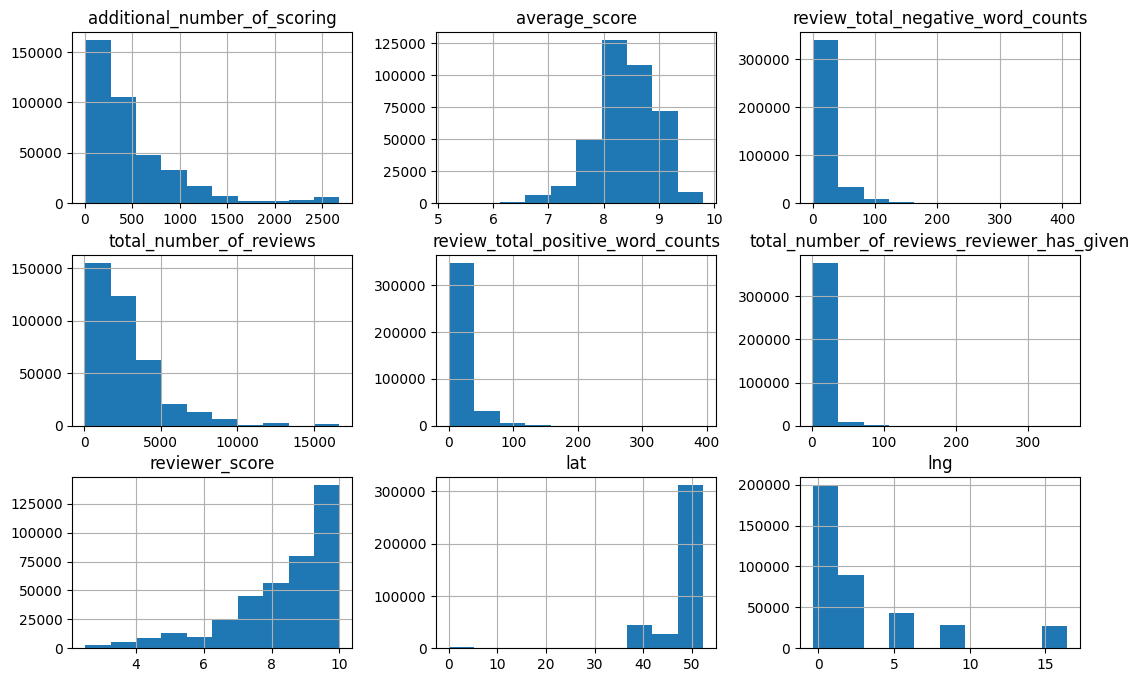

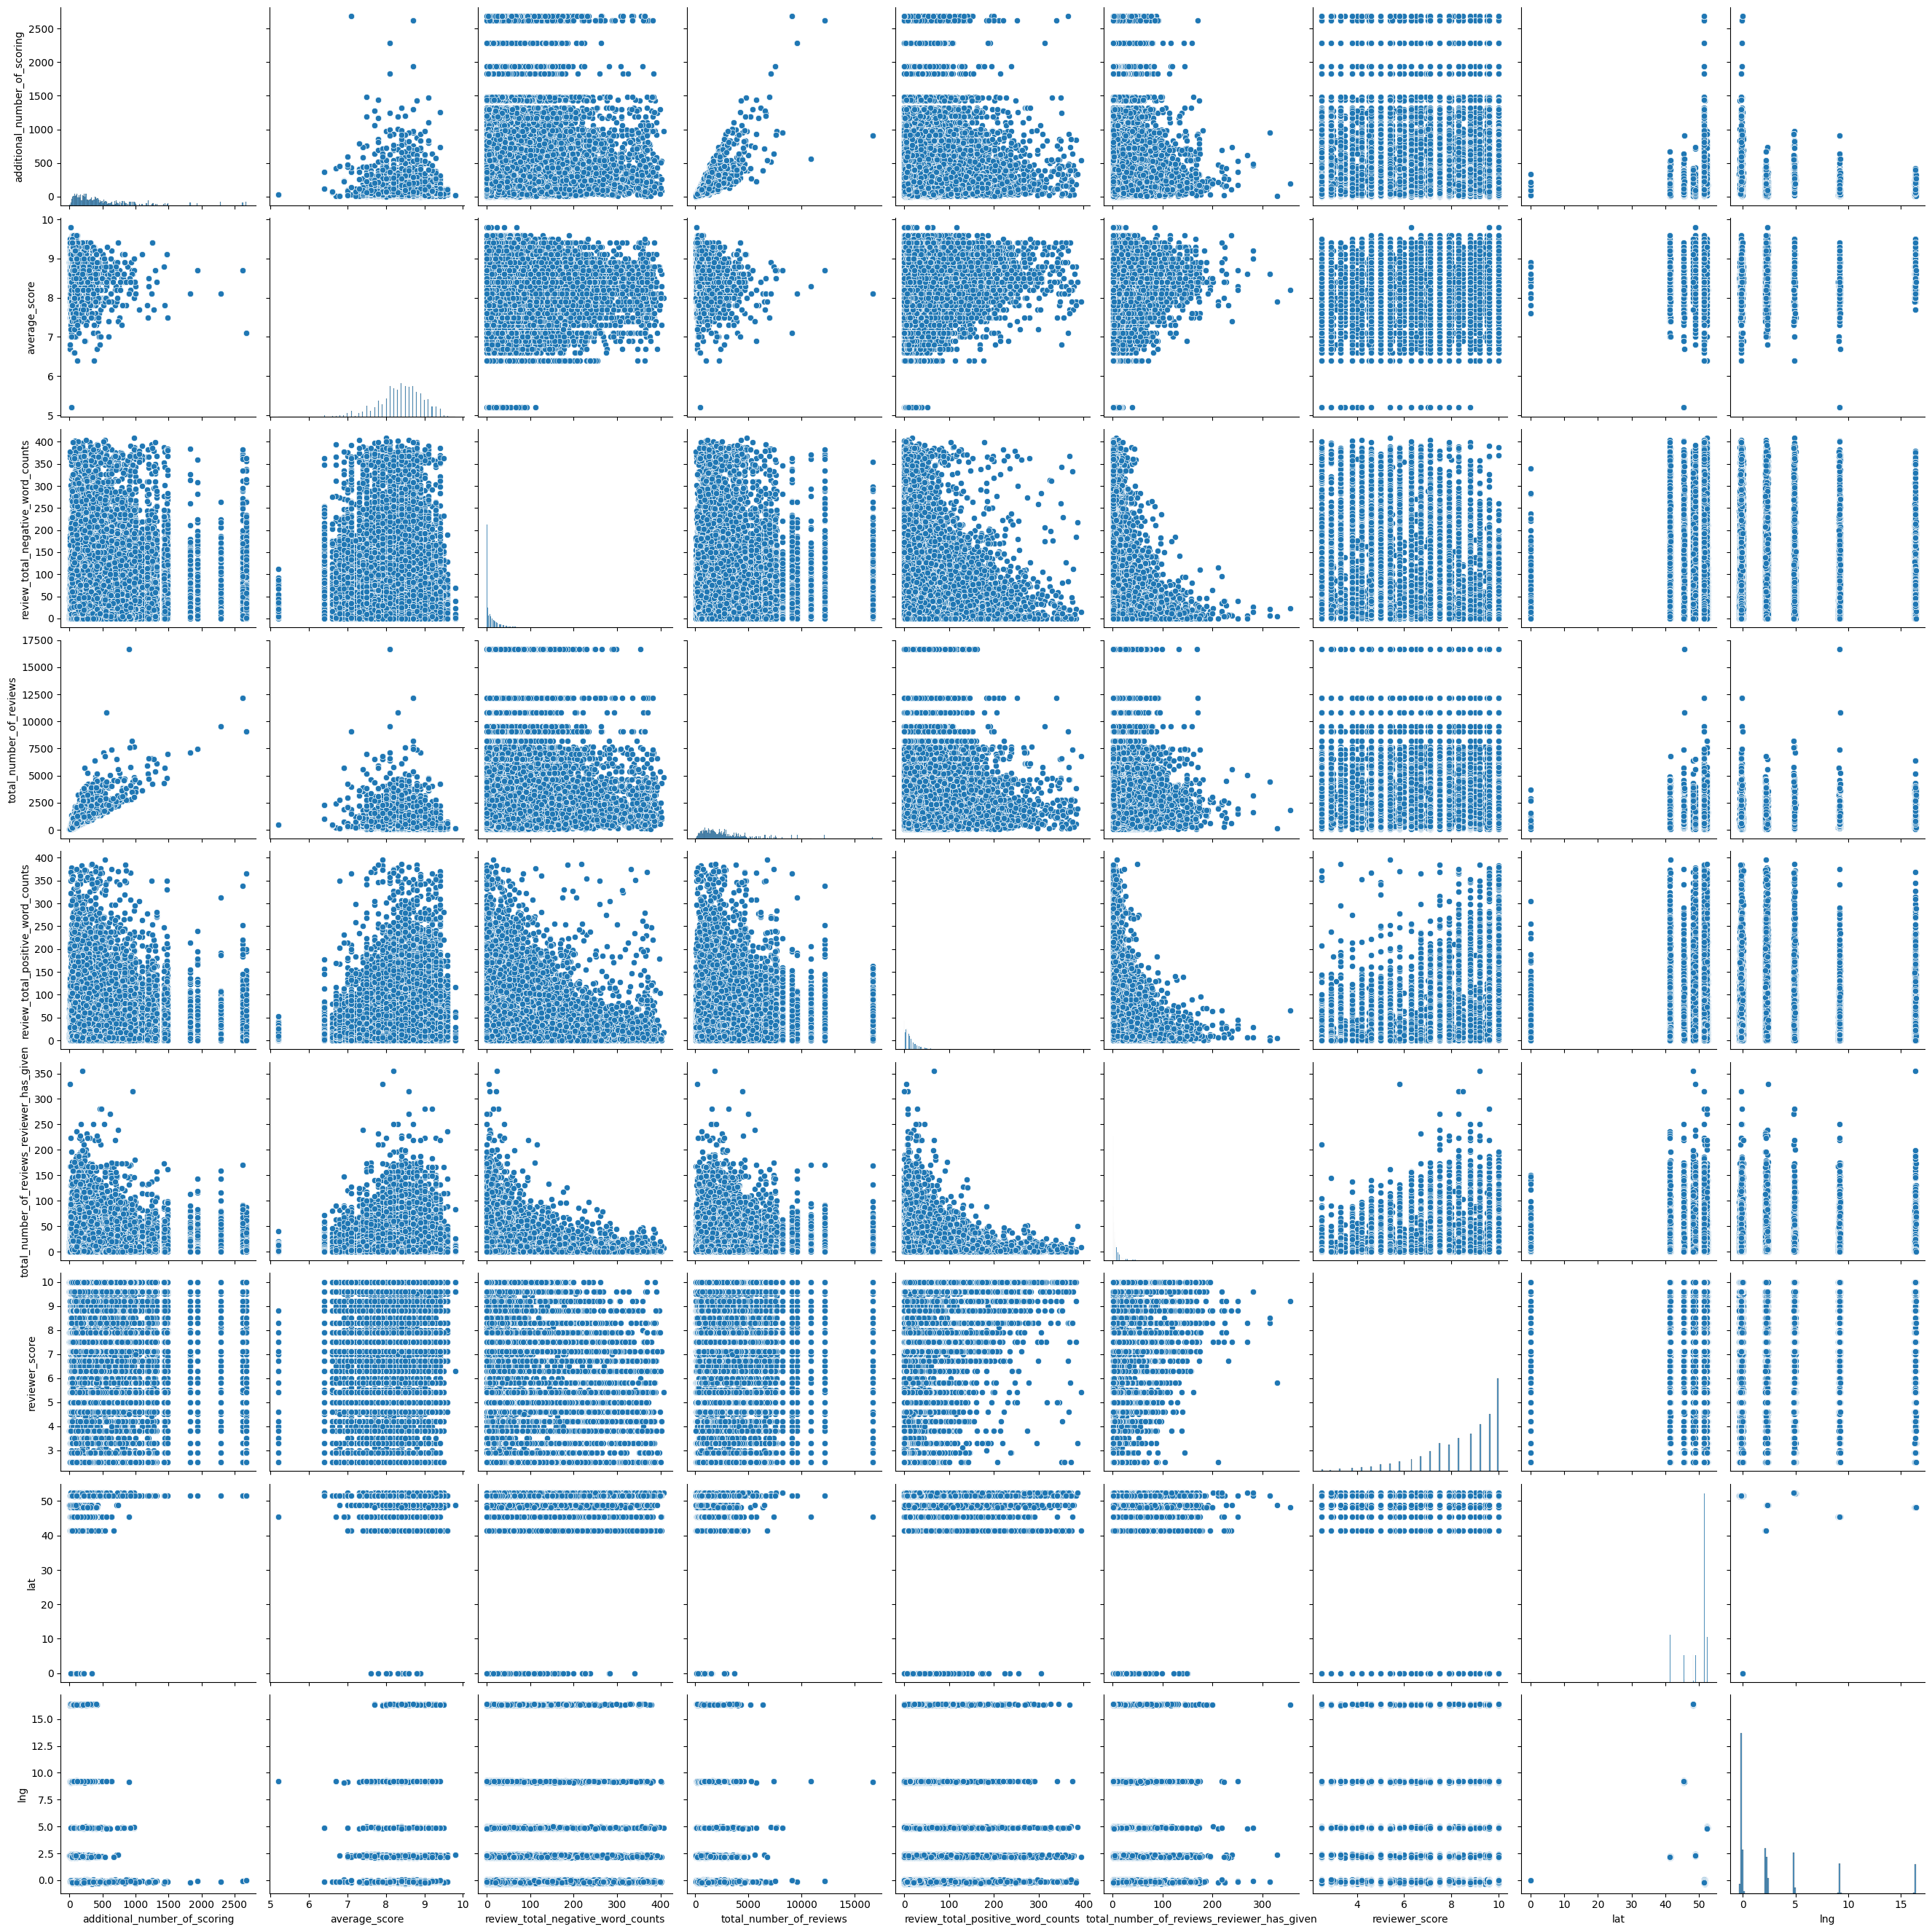

In [7]:
# Удаляем категориальные признаки, указанные в списке cat_features, и временной признак 'review_date'.
hotels_iter1 = hotels.copy()
hotels_iter1 = hotels_iter1.drop((cat_features+['review_date']), axis=1)
display(hotels_iter1)

# Заполняем пропуски самым простым способом
hotels_iter1 = hotels_iter1.fillna({'lat':0, 'lng':0}) # hotels_iter1 = hotels.fillna(0)

# Проверим с помощью функции possible_empty_values, как обстоят дела с пропусками
list_count_empty = possible_empty_values(hotels_iter1)
display(list_count_empty)
hotels_iter1.info()

# Посмотрим как распределены наши числовые признаки для первой итерации
hotels_iter1.hist(figsize=(13,8))
sns.pairplot(data=hotels_iter1, height=3.0, aspect=1.0);

*Как видно из распределений числовых признаков для первой итерации ни у одного из признаков не наблюдается нормального распределения.*

*Теперь попробуем постоить модель на данных для первой итерации. Для этого создаем матрицу наблюдений X и вектор правильных ответов y. Далее разбиваем всю выборку на тренировочную и тестовую в соотношении 75/25.*

*На тренировочной выборке будем обучать модели, а на тестовой проверять их качество.*

In [8]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels_iter1.drop(['reviewer_score'], axis = 1)  
y = hotels_iter1['reviewer_score'] # наш таргет

In [9]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split 

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Посмотрим на размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {} \n'.format(X_test.shape))

Train shape: (290102, 8)
Test shape: (96701, 8) 



In [10]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100, random_state=42)  
      
# Обучаем модель на тренировочном наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test) 

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.14136429245712825


*Продолжим подготовку и очистку данных, для улучшения показателя метрики и более лучшего прогноза модели.*

## Продолжение разведывательного анализа

In [11]:
# Для вывода основных статистических характеристик для числовых признаков воспользуемся методом describe() на предварительно очищенных данных
display(hotels.describe().T)
# Для вывода основных статистических характеристик для категориальных признаков на предварительно очищенных данных воспользуемся методом describe()
display(hotels.describe(include=['object', 'datetime64'])) #datetime_is_numeric=True))

# На основании основных статистических данных можно отметить некоторые моменты:
print(f"В наборе данных представлено {hotels['hotel_name'].nunique()} уникальных названий отелей из {hotels['hotel_address'].nunique()} уникальных адресов.\n\
А это значит, что в выборке есть несколько одинаковых названий отелей с разными адресами.\n")

# Посмотрим какие названия отелей задвоились:
s_address_name_hotel = set(list((hotels['hotel_address']+'/'+hotels['hotel_name']).sort_values())) # уникальное множество из массива существующих адрессов и названий отелей
list_name_hotel = list(set(hotels['hotel_name'])) # список из уникального множества названий отелей
# Создадим список из названий отелей в уникальном множестве существующих адрессов и названий отелей. Т.е выделим из него только названия отелей.
list_name_hotel_from_address_name_hotel=[]
for elem in s_address_name_hotel:
    string=elem.split('/')[1]
    list_name_hotel_from_address_name_hotel.append(string)
#print(len(list_name_hotel_from_address_name_hotel))
#display(s_address_name_hotel, len(s_address_name_hotel))
#display(list_name_hotel, len(list_name_hotel))
# Создадим список путем сравнения списка названий отелей в уникальном множестве существующих адрессов и названий отелей, и списка из уникального множества названий отелей
difference_list_name_hotel = []
for elem in list_name_hotel:
    if elem in list_name_hotel_from_address_name_hotel:
        count = list_name_hotel_from_address_name_hotel.count(elem)
        if count > 1:
            difference_list_name_hotel.append(elem)
print(f'Отель с одинаковым названием - {difference_list_name_hotel[0]}, но разными адресами.\n')

# Но стоит заметить это ещё не все аномалии, т.к. во множестве из массива существующих адрессов и названий отелей 1494 значения. 
# Нашли только одно одинаковое значение в названиях отеля, значит существует ещё одно в адресах. Т.е. к одному адресу присвоено несколько названий отелей 
list_address_hotel = list(set(hotels['hotel_address'])) # список из уникального множества адресов отелей
# Создадим список из адресов отелей в уникальном множестве существующих адрессов и названий отелей. Т.е выделим из него только адреса отелей.
list_address_hotel_from_address_name_hotel=[]
for elem in s_address_name_hotel:
    string=elem.split('/')[0]
    list_address_hotel_from_address_name_hotel.append(string)
#print(len(list_address_hotel_from_address_name_hotel))
# Создадим список путем сравнения списка адресов отелей в уникальном множестве существующих адрессов и названий отелей, и списка из уникального множества адресов отелей
difference_list_address_hotel = []
for elem in list_address_hotel:
    if elem in list_address_hotel_from_address_name_hotel:
        count = list_address_hotel_from_address_name_hotel.count(elem)
        if count > 1:
            difference_list_address_hotel.append(elem)
print(f'К адресу: {difference_list_address_hotel[0]} - присвоено несколько названий отелей.\n')

print(f"Самый свежий отзыв был оставлен в {hotels['review_date'].max()}")
print(f"А самый первый отзыв был оставлен в {hotels['review_date'].min()}")

count         mean  \
additional_number_of_scoring                386803.0   498.246536   
average_score                               386803.0     8.397231   
review_total_negative_word_counts           386803.0    18.538988   
total_number_of_reviews                     386803.0  2743.992042   
review_total_positive_word_counts           386803.0    17.776985   
total_number_of_reviews_reviewer_has_given  386803.0     7.177250   
reviewer_score                              386803.0     8.396906   
lat                                         384355.0    49.443522   
lng                                         384355.0     2.823402   

                                                    std        min  \
additional_number_of_scoring                 500.258012   1.000000   
average_score                                  0.547881   5.200000   
review_total_negative_word_counts             29.703369   0.000000   
total_number_of_reviews                     2316.457018  43.000000   
review_total_positive_word_counts             21.726141   0.000000   
total_number_of_reviews_reviewer_has_given    11.054420   1.000000   
reviewer_score                                 1.636090   2.500000   
lat                                            3.466936  41.328376   
lng                                            4.579043  -0.369758   

                                                    25%          50%  \
additional_number_of_scoring                 169.000000   342.000000   
average_score                                  8.100000     8.400000   
review_total_negative_word_counts              2.000000     9.000000   
total_number_of_reviews                     1161.000000  2134.000000   
review_total_positive_word_counts              5.000000    11.000000   
total_number_of_reviews_reviewer_has_given     1.000000     3.000000   
reviewer_score                                 7.500000     8.800000   
lat                                           48.214662    51.499981   
lng                                           -0.143649    -0.000250   

                                                    75%           max  
additional_number_of_scoring                 660.000000   2682.000000  
average_score                                  8.800000      9.800000  
review_total_negative_word_counts             23.000000    408.000000  
total_number_of_reviews                     3613.000000  16670.000000  
review_total_positive_word_counts             22.000000    395.000000  
total_number_of_reviews_reviewer_has_given     8.000000    355.000000  
reviewer_score                                 9.600000     10.000000  
lat                                           51.516288     52.400181  
lng                                            4.834443     16.429233

C:\Users\Хозяин\AppData\Local\Temp\ipykernel_12292\2438529559.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(hotels.describe(include=['object', 'datetime64'])) #datetime_is_numeric=True))


hotel_address  \
count                                              386803   
unique                                               1493   
top     163 Marsh Wall Docklands Tower Hamlets London ...   
freq                                                 3587   
first                                                 NaN   
last                                                  NaN   

                review_date                                  hotel_name  \
count                386803                                      386803   
unique                  731                                        1492   
top     2017-08-02 00:00:00  Britannia International Hotel Canary Wharf   
freq                   1911                                        3587   
first   2015-08-04 00:00:00                                         NaN   
last    2017-08-03 00:00:00                                         NaN   

       reviewer_nationality negative_review positive_review  \
count                386803          386803          386803   
unique                  225          248828          311737   
top         United Kingdom      No Negative     No Positive   
freq                 184033           95907           26885   
first                   NaN             NaN             NaN   
last                    NaN             NaN             NaN   

                                                     tags days_since_review  
count                                              386803            386803  
unique                                              47135               731  
top     [' Leisure trip ', ' Couple ', ' Double Room '...            1 days  
freq                                                 3853              1911  
first                                                 NaN               NaN  
last                                                  NaN               NaN

В наборе данных представлено 1492 уникальных названий отелей из 1493 уникальных адресов.
А это значит, что в выборке есть несколько одинаковых названий отелей с разными адресами.

Отель с одинаковым названием - Hotel Regina, но разными адресами.

К адресу: 8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom - присвоено несколько названий отелей.

Самый свежий отзыв был оставлен в 2017-08-03 00:00:00
А самый первый отзыв был оставлен в 2015-08-04 00:00:00


In [12]:
# Теперь займемся заполнением пропусков широты и долготы существующими значениями по их адресу (так как в адресах пропусков нет)

# Для начала проверим может быть такие же координаты уже есть в существующих данных
# Для этого создаем два множества названий отелей в данных с пропусками и без пропусков
s_nan=set(hotels[hotels['lat'].isna() & hotels['lng'].isna()]['hotel_name']) # c NaN
print(f'Всего {len(s_nan)} отелей не имеют значения координат.\n')
s_without_nan=set(hotels[~hotels['lat'].isna() & ~hotels['lng'].isna()]['hotel_name']) # без NaN
s_repeat=s_without_nan.intersection(s_nan) # есть ли повторяющиеся элементы во множествах
print(f'Во множествах нет повторений ({len(s_repeat)} повторений), а это значит надо искать во внешних источниках данные широты и долготы по адресу отеля.\n') 

# Во множествах нет повторений, а это значит надо искать во внешних источниках данные широты и долготы по адресу отеля
# Для этого нам понадобится библиотека geopy
from geopy.geocoders import Nominatim

# Берем только данные с пропусками и создаем там дополнительный признак с обновленными данными, которые будут нужны для API Геокодера
hotels_nan =(hotels[hotels['lat'].isna() & hotels['lng'].isna()]).copy()
hotels_nan['address_updated']=hotels_nan['hotel_address'].apply(lambda x: ' '.join(x.split()[-3:-1])+' '+''.join(x.split()[-1:]))
name_ind_con_city_list = list(set(hotels_nan['hotel_name']+', '+hotels_nan['address_updated'])) # cписок в виде названия отеля с индексом страной и городом, где находится отель, для более удобного поиска координат
print(name_ind_con_city_list)

# Создаём объект Nominatim и инициализируем API Nominatim с помощью параметра hotel_score_predictor (можно и через geoapiExercises всё равно мало толку. Единственный плюс бесплатно и без всяких регистраций).
geolocator = Nominatim(user_agent="hotel_score_predictor") # user_agent="hotel_score_predictor"
result_hs=hotels.drop(hotels.index)

# Проходим по всем отелям, в которых нет координат
for elem in name_ind_con_city_list:
    location = geolocator.geocode(query=elem, language='En', addressdetails=True)
    if elem == 'Hotel Advance, 08011 Barcelona Spain':
        coordinates = {'lat':41.38337532731557, 'lng':2.162971056490655}  # определено вручную по GoogleMaps
    elif elem == 'City Hotel Deutschmeister, 1090 Vienna Austria':
        coordinates = {'lat':48.220841175892915, 'lng':16.36669733047197}  # определено вручную по GoogleMaps   
    elif elem == 'Hotel Pension Baron am Schottentor, 1090 Vienna Austria':
        coordinates = {'lat':48.216805302314796, 'lng':16.35992324744888}  # определено вручную по GoogleMaps 
    elif elem == 'Mercure Paris Gare Montparnasse, 75014 Paris France':
        coordinates = {'lat':48.83800120223257, 'lng':2.3185374379381485}  # определено вручную по GoogleMaps
    elif elem == 'Fleming s Selection Hotel Wien City, 1080 Vienna Austria':
        coordinates = {'lat':48.20939551517178, 'lng':16.35350058211183}  # определено вручную по GoogleMaps
    elif elem == 'Derag Livinghotel Kaiser Franz Joseph Vienna, 1190 Vienna Austria':
        coordinates = {'lat':48.246141730859215, 'lng':16.341514839159586}  # определено вручную по GoogleMaps
    elif elem == 'Maison Albar Hotel Paris Op ra Diamond, 75008 Paris France':
        coordinates = {'lat':48.87533823998107, 'lng':2.3233908470938887}  # определено вручную по GoogleMaps
    else:
        coordinates = {'lat':location.latitude, 'lng':location.longitude}
    hs=hotels[hotels['hotel_name']==elem.split(',')[0]].fillna(coordinates) # замена пропусков для конкретного отеля
    result_hs=pd.concat([result_hs, hs]) # объединение в общий датафрейм с замененными координатами
#display(result_hs) 
       
#import requests
#from pprint import pprint
#pprint(location)
#print(location)
#print(coordinates)

Всего 17 отелей не имеют значения координат.

Во множествах нет повторений (0 повторений), а это значит надо искать во внешних источниках данные широты и долготы по адресу отеля.

['Hotel Park Villa, 1190 Vienna Austria', 'NH Collection Barcelona Podium, 08010 Barcelona Spain', 'Roomz Vienna, 1110 Vienna Austria', 'Renaissance Barcelona Hotel, 08009 Barcelona Spain', 'Derag Livinghotel Kaiser Franz Joseph Vienna, 1190 Vienna Austria', 'Fleming s Selection Hotel Wien City, 1080 Vienna Austria', 'Holiday Inn Paris Montmartre, 75018 Paris France', 'Hotel Atlanta, 1090 Vienna Austria', 'Maison Albar Hotel Paris Op ra Diamond, 75008 Paris France', 'Hotel Advance, 08011 Barcelona Spain', 'Austria Trend Hotel Schloss Wilhelminenberg Wien, 1160 Vienna Austria', 'Hotel Pension Baron am Schottentor, 1090 Vienna Austria', 'Mercure Paris Gare Montparnasse, 75014 Paris France', 'Cordial Theaterhotel Wien, 1080 Vienna Austria', 'Hotel Daniel Vienna, 1030 Vienna Austria', 'City Hotel Deutschmeister, 

In [13]:
# Удаляем строки с пропущенными значениями
hotels=hotels.dropna()

# Объединяем датафрейм с основными данными с датафреймом с замененными координатами в один
hotels = pd.concat([hotels,result_hs]).sort_index()


In [14]:
hotels.info()
# Пришло время проверить имеются ли полные дубликаты в наших данных
dublicat=hotels.duplicated(subset=hotels.columns)
# Находим количество дубликатов
print(f'Число найденных дубликатов: {hotels[dublicat].shape[0]}')
# Удаляем найденные дубликаты
hotels = hotels.drop_duplicates(subset=hotels.columns).reset_index(drop=True)
print(f'Число записей после удаления дубликатов составляет: {hotels.shape}')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  int64         
 8   total_number_of_reviews                     386803 non-null  int64        

In [15]:
# Посмотрим совпадает ли количество адресов и координат:
print(f"Количетство уникальных значений широты составляет {len(set(hotels['lat']))},\nи количество - значений долготы {len(set(hotels['lng']))},\n\
но вот количество адресов {hotels['hotel_address'].nunique()}. Из этого следует, что значения координат задублированы. Найдем их.")
# Создаем выборку отелей с отзывом, который считается последним по этому отелю:
hotels_max_date=hotels.drop(hotels.index)
for elem in set(hotels['hotel_address']):
    hotel_max_date=hotels[hotels['hotel_address']==elem].sort_values(by='review_date', ascending=False).reset_index(drop=True).iloc[:1,:]
    hotels_max_date=pd.concat([hotels_max_date, hotel_max_date]).reset_index(drop=True)
#display(hotels_max_date)
# Теперь находим задублированные координаты
dublicat_coor=hotels_max_date.duplicated(subset=['lat', 'lng'], keep=False)
hotels_dublicat_coor = hotels_max_date[dublicat_coor].copy()
display(hotels_max_date[dublicat_coor])

# Вносим исправление в координаты для найденных дубликатов через
# создание объекта Nominatim и инициализируем API Nominatim с помощью параметра hotel_score_predictor
# Возмем данные с задублированными координатами и создаем там дополнительный признак с обновленными данными, которые будут нужны для API Геокодера
hotels_dublicat_coor['address_updated']=hotels_dublicat_coor['hotel_address'].apply(lambda x: ' '.join(x.split()[-3:-1])+' '+''.join(x.split()[-1:]))
name_ind_con_city_list = list(set(hotels_dublicat_coor['hotel_name']+', '+hotels_dublicat_coor['address_updated'])) # cписок в виде названия отеля с индексом страной и городом, где находится отель, для более удобного поиска координат
#print(name_ind_con_city_list)
geolocator = Nominatim(user_agent="hotel_score_predictor") 
result_hs_correct_coor=hotels_dublicat_coor.drop(hotels_dublicat_coor.index)
for elem in name_ind_con_city_list:
    #print(elem)
    location = geolocator.geocode(query=elem, language='En', addressdetails=True)
    if elem == '41, 0PS United Kingdom':
        coordinates = {'lat':51.49823832458419, 'lng':-0.14352335623288043}  # определено вручную по GoogleMaps
    elif elem == 'Corus Hotel Hyde Park, 3LG United Kingdom':
        coordinates = {'lat':51.51175393283963, 'lng':-0.17754780701306977}  # определено вручную по GoogleMaps 
    elif elem == 'Lancaster London, 2TY United Kingdom':
        coordinates = {'lat':51.512323857543215, 'lng':-0.1751985865960704}  # определено вручную по GoogleMaps 
    elif elem == 'Holiday Inn Milan Garibaldi Station, 20159 Milan Italy':
        coordinates = {'lat':45.488851419090295, 'lng':9.183127498473187}  # определено вручную по GoogleMaps
    elif elem == 'Rubens At The Palace, 0PS United Kingdom':
        coordinates = {'lat':51.498351329422434, 'lng':-0.1435418498178561}  # определено вручную по GoogleMaps
    else:
        coordinates = {'lat':location.latitude, 'lng':location.longitude} 
    #print(coordinates)
    hotels_dublicat_coor['lat']=hotels_dublicat_coor[hotels_dublicat_coor['hotel_name']==elem.split(',')[0]]['lat'].\
    replace([hotels_dublicat_coor[hotels_dublicat_coor['hotel_name']==elem.split(',')[0]]['lat'].iloc[0]], list(coordinates.values())[0]) # корректировка координат для конкретного отеля / replace([hotels_dublicat_coor['lat'].iloc[0]], list(coordinates.values())[0])
    hotels_dublicat_coor['lng']=hotels_dublicat_coor[hotels_dublicat_coor['hotel_name']==elem.split(',')[0]]['lng'].\
    replace([hotels_dublicat_coor[hotels_dublicat_coor['hotel_name']==elem.split(',')[0]]['lng'].iloc[0]], list(coordinates.values())[1]) # replace([hotels_dublicat_coor['lng'].iloc[0]], list(coordinates.values())[1]) практически тоже самое, что и с фильтром по названию отеля
    #display(hotels_dublicat_coor)
    result_hs_correct_coor=pd.concat([result_hs_correct_coor, hotels_dublicat_coor]) # объединение в общий датафрейм с замененными координатами
    result_hs_correct_coor=result_hs_correct_coor[~result_hs_correct_coor['lat'].isna()].sort_index()
#display(result_hs_correct_coor)

Количетство уникальных значений широты составляет 1489,
и количество - значений долготы 1489,
но вот количество адресов 1493. Из этого следует, что значения координат задублированы. Найдем их.


hotel_address  \
214   Corso Buenos Aires 42 5 Central Station 20124 ...   
268   Lancaster Terrace Westminster Borough London W...   
383   39 Buckingham Palace Road Westminster Borough ...   
415   6 Via Aristotile Fioravanti Garibaldi Station ...   
614   Lancaster Gate Westminster Borough London W2 3...   
707   Via G B Pirelli 7 Central Station 20124 Milan ...   
1136  41 Buckingham Palace Road Westminster Borough ...   
1452  Via Ugo Bassi 1 A Ang Via C Farini Garibaldi S...   

      additional_number_of_scoring review_date  average_score  \
214                             84  2017-08-03            8.4   
268                            365  2017-08-03            8.3   
383                            332  2017-08-03            8.7   
415                             30  2017-08-03            8.9   
614                            452  2017-08-03            7.6   
707                            113  2017-08-03            8.2   
1136                            66  2017-07-16            9.6   
1452                            45  2017-08-02            8.3   

                               hotel_name        reviewer_nationality  \
214               Best Western Hotel City             United Kingdom    
268                      Lancaster London                  Australia    
383                  Rubens At The Palace   United States of America    
415                       Hotel VIU Milan               Saudi Arabia    
614                 Corus Hotel Hyde Park             United Kingdom    
707                          Hotel Auriga             United Kingdom    
1136                                   41   United States of America    
1452  Holiday Inn Milan Garibaldi Station                Switzerland    

                                        negative_review  \
214                                         No Negative   
268    The bar fridge was connected to reception and...   
383                       That we couldn t stay longer    
415                              Location in China town   
614                                         No Negative   
707                              No toast Only 1 pillow   
1136                                        No Negative   
1452   The kinder loft bed is not safety There is no...   

      review_total_negative_word_counts  total_number_of_reviews  \
214                                   0                     1193   
268                                 113                     1463   
383                                   8                     1449   
415                                   5                      219   
614                                   0                     2562   
707                                   6                     1299   
1136                                  0                      244   
1452                                 23                      484   

                                        positive_review  \
214    Welcoming staff clean modern room great locat...   
268    Our room had been renovated and redecorated a...   
383    The room was very comfortable quiet and spaci...   
415     The design the quality of Furnture the roof bar   
614    The rooms were decorated beautifully and the ...   
707    Coffee was very good sufficient choice of cer...   
1136   Extraordinarily attentive staff and 24hr snac...   
1452                                        No Positive   

      review_total_positive_word_counts  \
214                                   9   
268                                 122   
383                                  48   
415                                  10   
614                                  12   
707                                  13   
1136                                  9   
1452                                  0   

      total_number_of_reviews_reviewer_has_given  reviewer_score  \
214                                            4            10.0   
268                                           15             9.2 

In [ ]:
# Итак, произведем корректировку координат во всех данных:
#hotels['lat']=hotels['lat'].replace(hotels_max_date[dublicat_coor]['lat'].values, result_hs_correct_coor['lat'].values) #при повторных значения в первом списке проставляет последнее значение во втором списке для значения, которое пытаемся заменить, что пораждает новые дубли
# Поэтому нужно создать жесткую сцепку конкретного значения координат с названием отеля:
hotels_copy=hotels.copy()
hotels_in_to = hotels.drop(hotels.index)
for elem in result_hs_correct_coor['hotel_name']:
    hotels_copy['lat']=hotels_copy[hotels_copy['hotel_name']==elem]['lat'].replace([hotels_copy[hotels_copy['hotel_name']==elem]['lat'].iloc[0]],\
        [result_hs_correct_coor[result_hs_correct_coor['hotel_name']==elem]['lat'].iloc[0]])
    hotels_copy['lng']=hotels_copy[hotels_copy['hotel_name']==elem]['lng'].replace([hotels_copy[hotels_copy['hotel_name']==elem]['lng'].iloc[0]],\
        [result_hs_correct_coor[result_hs_correct_coor['hotel_name']==elem]['lng'].iloc[0]])
    hotels_in_to = pd.concat([hotels_in_to, hotels_copy])
    hotels_in_to = hotels_in_to[~hotels_in_to['lat'].isna()]
#display(hotels_in_to)

# Можно убидится наглядно в правильности замены:
#display(hotels_max_date[dublicat_coor][['hotel_name']+['lat']+['lng']])
#display(result_hs_correct_coor[['hotel_name']+['lat']+['lng']])
#hotels_in_to[hotels_in_to['hotel_name']=='Corus Hotel Hyde Park'].sort_values(by=['review_date'], ascending=False)

# Заменяем массив с корректными данными с общими данными:
hotels.update(hotels_in_to)

# Теперь создаем выборку отелей с отзывом, который считается последним по этому отелю на корректных данных:
hotels_max_date=hotels.drop(hotels.index)
for elem in set(hotels['lat']):
    hotel_max_date=hotels[hotels['lat']==elem].sort_values(by='review_date', ascending=False).reset_index(drop=True).iloc[:1,:]
    hotels_max_date=pd.concat([hotels_max_date, hotel_max_date]).reset_index(drop=True)
#display(hotels_max_date)

# Построим интерактивную карту и отследим изменение среднего балла отеля в зависимости от его локации на момент последнего отзыва для конкретного отеля:
import plotly.express as px
fig = px.scatter_geo(hotels_max_date,lat='lat',lon='lng', hover_name='hotel_name', color='average_score',
                     title='Распределение отелей по среднему рейтингу в зависимости от их местоположения на момент последнего отзыва.', labels={'average_score':'Средний балл отеля'})
# Как видим, что отели в наших данных распределились в крупных городах, добавим координаты этих городов
# Выделим и добавим признак город и страну 
hotels['City'] = hotels['hotel_address'].apply(lambda x: x.split(' ')[-2] if x.split(' ')[-1] != 'Kingdom' else x.split(' ')[-5])
hotels['Country'] = hotels['hotel_address'].apply(lambda x: x.split(' ')[-1] if x.split(' ')[-1] != 'Kingdom' else 'United Kingdom')
# Находим координаты для городов через создание объекта Nominatim и инициализируем API Nominatim "geoapiExercises"
geolocator = Nominatim(user_agent="geoapiExercises") #"geoapiExercises" "hotel_score_predictor"
city_center_coordinates = dict() 
for elem in set(hotels['City']):
     location = geolocator.geocode(query=elem, language='En', addressdetails=True)
     city_center_coordinates[elem] = (location.latitude, location.longitude)
fig.show()

![SNOWFALL](diagrams/newplot1.png)

*Как можно заметить, что наиболее плотное распределение отелей наблюдается в крупных городах. Также можно заметить при небольшом приближении карты, что более высокие средние баллы в рейтинге отмечаются в Лондоне и Амстердаме (на диаграмме желтый цвет, примерно 9.0-9.5 баллов), на втором месте Париж, Милан и Вена (на диаграмме рыжий цвет, примерно 8.5-9.0 баллов) и на третьем месте Барселона (на диаграмме преобладает красный цвет, примерно 8.0-8.5 баллов).*

In [ ]:
# Получаем датафрейм с координатами городов
city_center_coordinates_df=pd.DataFrame(city_center_coordinates, index=['lat', 'lng'])
# Добавляем координаты ценров городов на нашу карту распределения среднего рейтинга балла отеля
fig.add_trace(px.scatter_geo(data_frame=city_center_coordinates_df, lat=city_center_coordinates_df.loc['lat'], lon=city_center_coordinates_df.loc['lng'],\
    hover_name=city_center_coordinates_df.columns, color_discrete_sequence= ['yellowgreen']).data[0]).\
update_layout(title_text="Распределение отелей по среднему рейтингу в зависимости от их местоположения на момент последнего отзыва и расположение центра города, в которых они находятся.",\
title_font_size=15, title_xanchor='center', title_x=0.5)
fig.show()

![SNOWFALL](diagrams/newplot2.png)

*В более близком масштабе и детальном рассмотрении карты, на которой уже указаны координаты центров городов, сложно точно сказать есть ли прямая зависимость среднего балла рейтинга от близкого расположения к центру города, так как имеются отели с низким рейтингом как на периферии, так и немало отелей возле центра. Поэтому для более глубокого анализа данной зависимости создадим новый признак расстояние от центра города до отеля.*

In [24]:
# Создаем новый признак расстояние от центра города до отеля, 
# которое определяем через геодезическое расстояние через модуль distance с помощью одноименной функции distance.
from geopy import distance
hotels['distance_from_center_to_hotel'] = hotels.apply(lambda x: round(distance.distance(city_center_coordinates[x['City']], (x['lat'],x['lng'])).km, 3), axis=1)

In [25]:
# Перейдем теперь к признаку тегов
# Создаем список всех существующих тегов, исходя из представленных значений в признаке 'tags'
list_tags=[] # пустой список, в котором будет добавляться возможные варианты тегов
for string in hotels['tags']: # проходим по всем строкам в признаке 'tags'
    string=string.strip("[' ']").split(" ', ' ")
    #print(string)
    list_tags+=string # собраны все теги предсавленные в каждой строке
# Посмотрим какое количество уникальных тегов представлено в наборе данных:
print(f'Итак, количество уникальных тегов представлено в наборе данных составляет: {len(set(list_tags))} тегов')
	
# Проследим какие тэги являются наиболее популярными с помощью создания словаря с ключами в виде возможных тегов и значениями - количество повторений этих тегов в данных.
#dict_tags ={} # пустой словарь, в котором будет добавляться уникальные тэги и количество повторений этих тегов в данных
#for elem in set(list_tags):
#        dict_tags[elem] = list_tags.count(elem)
dict_tags = {elem:list_tags.count(elem) for elem in set(list_tags)} # можно создать словарь через использование генератора словаря
# Отсортируем словарь с помощью sorted, чтобы посмотреть часто встречаемые теги
sorted_dict_tags = dict(sorted(dict_tags.items(), key= lambda x: x[1], reverse=True))
#print(sorted_dict_tags)
print(f"Наиболее популярным тегом является - '{max(dict_tags, key=dict_tags.get)}'")

Итак, количество уникальных тегов представлено в наборе данных составляет: 2368 тегов
Наиболее популярным тегом является - 'Leisure trip'


In [26]:
# Удобнее просмотреть все виды тегов в датафрейме, поэтому создадим его. А также выделим 50 наиболее популярных значений тегов.
df_tags = pd.DataFrame({'tags':sorted_dict_tags.keys(), 'count':sorted_dict_tags.values()})
df_tags_popular = df_tags.nlargest(50, columns='count')
# Попробуем разделить теги на разные признаки, так как в нем смешены различные характеристики
# (характеристики номеров/комнат, количество ночей прибывания в отели, вид путешествия и др.)
# Вызываем библиотеку регулярных выражений
import re

df_tags_room = df_tags['tags'].apply(lambda x: x if len(re.findall(r'room|Room|Suite|suite|Studio|Deluxe|Luxury|Superior|Standard|Privilege|Duplex|Double|\
|Apartment|Apartement|King|Queen|View|Offer|Premium|Penthouse|Loft|Cottage|Designer|Atrium|Maisonette|Townhouse|Classique|Cosy|Maison|Cool|Bank|Park|Rooks|PLAN',x))>0 else 'not found')
df_tags_inter_1 = df_tags.loc[list(df_tags_room[df_tags_room=='not found'].index), :]
df_tags_count_nights = df_tags_inter_1['tags'].apply(lambda x: x if len(re.findall(r'Stayed',x))>0 else 'not found')
df_tags_inter_2 = df_tags.loc[list(df_tags_count_nights[df_tags_count_nights=='not found'].index), :]
df_tags_types = df_tags_inter_2['tags'].apply(lambda x: x if len(re.findall(r'trip',x))>0 else 'not found')
df_tags_inter_3 = df_tags.loc[list(df_tags_types[df_tags_types=='not found'].index), :]
df_tags_number_of_travelers = df_tags_inter_3[df_tags_inter_3['tags']!='Submitted from a mobile device']['tags']

df_tags_room = df_tags_room[df_tags_room!='not found']
df_tags_count_nights = df_tags_count_nights[df_tags_count_nights!='not found']
df_tags_types = df_tags_types[df_tags_types!='not found']

# На основе разделенных тегов создадим новые признаки:
# Создадим порядковый категориальный признак 'count_nights', содержащий информацию о том, сколько ночей провел рецензент в отеле
hotels['count_nights'] = hotels['tags'].apply(lambda x: int(re.findall(r'Stayed ([\d]+) night', x)[0]) \
if len(re.findall(r'Stayed ([\d]+) night', x))>0 else 0) # не указано число ночей (undefined) примем равным 0
# Создадим номинальный категориальный признак 'types_of_trips', содержащий информацию о типе поездки
hotels['types_of_trips'] = hotels['tags'].apply(lambda x: re.findall(pattern='|'.join(df_tags_types.values), string=x)[0]\
if len(re.findall(pattern='|'.join(df_tags_types.values), string=x))>0 else 'unspecified')
# Создадим номинальный категориальный признак 'number_of_travelers', содержащий информацию о количестве путешественников
#df_tags_number_of_travelers_new_sort_index = df_tags_number_of_travelers.rename(index={8:df_tags_number_of_travelers.iloc[len(df_tags_number_of_travelers)-1:].index[0]+1}).sort_index() # для этого отсортируем чуть по другому, чтобы значение 'Group' оказалось последним
hotels['number_of_travelers'] = hotels['tags'].apply(lambda x: re.findall(pattern='|'.join(df_tags_number_of_travelers.values), string=x)[0])
# Создадим бинарный категориальный признак способ отправки отзыва(отправлен ли отзыв с мобильного устройства Да/Нет или 1/0)
hotels['sent_from_a_mobile_device'] = hotels['tags'].apply(lambda x: 1 if len(re.findall(r'Submitted from a mobile device', x))>0 else 0)

print(f"Чаще всего путешественники останавливаются на {hotels['count_nights'].value_counts(normalize=True).index[0]} ночь")

# Далее создадим 17 бинарных признаков (признаков-мигалок) наиболее встречающихся номеров (так называемых характеристики номеров/комнат), про которые оставляли отзывы.
# Где 1 (Да) - это наличие в выборке данного топового номера, а 0 - отсутствие (и наличие любого другого номера other).
df_tags_room_percent = (df_tags.iloc[list(df_tags_room.index), :]['count'].iloc[:17].sum())/hotels.shape[0]*100 # В этих 17 признаках будет представлен 51,3% (198306/386496=0,513)
                                                                                                                # всех имеющихся значений в выборке характеризирующих номер(комнату) отеля.
#display(df_tags_room_percent.round(1))
# Так как ранее был отсортирован словарь sorted_dict_tags (от большего  к меньшему) на основе которого был создан датафрейм всех видов тегов и их количества вхождений df_tags,
# то можно смело воспользоваться им для построения заявленных 17 признаков (топовых номеров отелей)
for elem in df_tags_room.iloc[0:17]:
  hotels[elem] =  hotels['tags'].apply(lambda x: 1 if len(re.findall(pattern=elem, string=x))>0 else 0)
# Из этих 17 признаков видим, что наибольшее количество описывает двухместные номера с различными характеристиками комфортности, присутствует также и одноместный номер.
# Возможно для удобства работы модели с данными и не нужно столько специфических характеристик номеров, пока оставим так и посмотрим как будет работать модель. 

Чаще всего путешественники останавливаются на 1 ночь


In [27]:
# Давайте также определимся с признаком 'days_since_review'  количество дней между датой проверки и датой очистки (в буквальном переводе с оригинала источника данных
# ещё не понятней - дни с момента отзыва: период между датой отзыва и датой удаления). На сколько я понимаю и это видно из статистических характеристик,
# когда обращались с помощью метода describe() (одинаковое количество уникальных значений с признаком 'review_date' - даты размещения отзыва,
# одинаковая дата самого повторяемого значения 2017-08-02 и сама частота повторения этого значения 1911 раз), что это интервальный признак, указывающий число дней от конечной даты 
# выгрузки (а это 2017-08-03) до даты когда был оставлен отзыв (а начальная дата выгзруки данных 2015-08-04). Этот признак характеризует отзыв во времени,
# т.е. на сколько отзыв является старым.
# Проверим данное утверждение. Но сначала переведем признак 'days_since_review' в числовой формат.
hotels['days_since_review_to_the_end_of_the_upload_date'] = hotels['days_since_review'].apply(lambda x: int(re.findall(r'([\d]+)\sday|days', x)[0]))
# Создадим датафрейм, в котором посчитаем разницу между признаком предоставленным с данными (и переименнованным в 'days_since_review_to_the_end_of_the_upload_date')
# и посчитанным через указание крайней даты выгрузки и даты оставления отзыва.
diff_df_upload = hotels[['review_date','days_since_review_to_the_end_of_the_upload_date']]
for_diff_df_upload = (pd.to_datetime('2017-08-03')- diff_df_upload['review_date']).dt.days.rename('days_since_review') # если указывать сразу в датафрейме, то вылезает предупреждение, поэтому через series
diff_df_upload = pd.concat([diff_df_upload, for_diff_df_upload], axis=1) 
diff_df_upload['diff'] = diff_df_upload['days_since_review_to_the_end_of_the_upload_date']-diff_df_upload['days_since_review']
diff_df_upload['diff'].value_counts() # как видим разница (different) равна 0 по всем позициям, а это значит утверждение правильное.

0    386496
Name: diff, dtype: int64

*После предварительной очистки данных (а именно проведено заполнение пропусков координат отелей, удалены полные дубликаты, найдены и откорректированы задублированные координаты отелей,  переведен признак 'days_since_review' в числовой формат), и создания некоторых признаков из существующих ('City', 'Country', 'distance_from_center_to_hotel', 'count_nights', 'types_of_trips', 'number_of_travelers', 'sent_from_a_mobile_device'  и 17 признаков наиболее встречающихся номеров (топовых номеров, про которые оставлено больше всех отзывов)) проведем вторую итерацию обучения на той же модели с более лучше подготовленными данными и посмотрим изменился ли результат метрики MAPE.*

##  Итерация №2

*Проведем обучение нашей модели на более подготовленных данных*.

In [28]:
# Для этого удалим признаки, которые дублируют информацию - это 'hotel_address' (есть признаки с координатами),
# 'tags' (так как информация из этого признака была переработана в новые признаки/характеристики),
# 'review_date' и 'days_since_review' (аналогичный признак, который показывает на сколько отзыв является старым во временном интервале откорректирован 'days_since_review_to_the_end_of_the_upload_date'),
# 'City' и 'Country' (на данный момент для модели несет дублирующую информацию (разбивка выборки на 6 частей, что по городам, что по странам, поэтому оставим только признак города)
# Удалим также категориальные признаки, с которыми пока еще не работали: 'reviewer_nationality', 'negative_review', 'positive_review' и 'hotel_name'
hotels_iter2 = hotels.copy()
hotels_iter2 = hotels_iter2.drop(['hotel_address', 'tags', 'review_date', 'days_since_review', 'Country', 'reviewer_nationality', 'negative_review', 'positive_review', 'hotel_name'], axis=1)
#display(hotels_iter2)

# Теперь закодируем созданные номинальные категориальные признаки 'City', 'types_of_trips', 'number_of_travelers'
# воспользуемся однократным кодированием (OneHot Encoding) в библиотеке category_encoders.
# импортируем библиотеку для работы с кодировщиками
import category_encoders as ce
# создаем объект OneHotEncoder
one_hot_encoder = ce.OneHotEncoder(cols=['City', 'types_of_trips', 'number_of_travelers'], use_cat_names=True) # указываем признаки для кодирования
# трансформируем наши данные
hotels_iter2_encrypted = one_hot_encoder.fit_transform(hotels_iter2)

# Разделим набор данных на матрицу наблюдений X и вектор правильных ответов y:
X = hotels_iter2_encrypted.drop(['reviewer_score'], axis=1)
y = hotels_iter2_encrypted['reviewer_score']
# Разделяем исходную выборку на тренировочную и тестовую в соотношении 75/25. Задаем параметр random_state = 42.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.25)
# Посмотрим на размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {} \n'.format(X_test.shape))

Train shape: (289872, 45)
Test shape: (96624, 45) 



In [29]:
# Создаём объект класса случайный лес для регрессии (создаем модель)
regr = RandomForestRegressor(n_estimators=100, random_state=42)  
      
# Обучаем модель на тренировочном наборе данных  
regr.fit(X_train, y_train)

# Делаем предсказание рейтинга отелей для тестовой выборки
y_test_pred = regr.predict(X_test) 

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются
# Рассчитываем значение метрики Mean Absolute Percentage Error (MAPE-cредняя абсолютная процентная ошибка предсказанных значений от фактических) для тестовой выборки: 
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_test_pred))        

MAPE: 0.13667064381777042


*Можно заметить улучшение метрики MAPE при первой итерации модель ошибалась в результатах в среднем на 14,14%, а при второй итерации уже на 13,67% (улучшение на 0,47%).*

*Попробуем ещё сильнее улучшить показателя метрики для более лучшего прогноза модели. Продолжим создание и улучшение факторов (признаков).*

## Продолжение разведывательного анализа

In [30]:
# Возвратимся к характеристикам описывающим номер\комнату в отели, чтобы не путать модель различными специфическими характеристиками комфортности,
# нахождение дополнительных кроватей, описанием видов и другими специфическими характеристиками, выделим из этого многообразия
# два признака характеризующих номер по кол-ву комнат, размеру, кол-ву мест и по комфортабильности.
# Создадим копию для 3-й итерации
hotels_for_iter3 = hotels.copy()
# В этой копии удалим ранее созданные 17 признаков (топовых номеров отелей)
hotels_for_iter3 = hotels_for_iter3.drop(columns=df_tags_room.iloc[0:17])
# Создадим признак, характерезующий номер по кол-ву комнат, размеру, кол-ву мест 
# (таким образом произведем разметку большого количества специфических данных на более понятные группы по кол-ву комнат, размеру, кол-ву мест)
hotels_for_iter3['categories_by_size_and_composition'] = hotels_for_iter3['tags'].apply(lambda x: 'single rooms' if len(re.findall(r'Single Room|with 1 Single Bed|with Sofa Bed| \
|One Bedroom Suite|Single Guest|One Bed Feature|Suite with Sofa Bed|1 Bed|1 Adult|Single Hilton|Single Cabin|Suite Single|Solo Room',x))>0 \
else('twin rooms' if len(re.findall(r'Twin Room|with 2 Single Beds|Twin Guest|Twin Hilton|2 double beds 2 Adults|2 Twin Single Bed|Two Single Beds| \
|2 Single Bed|Twin|2 zip beds|2 Zip Beds',x))>0 \
else('quadruple rooms' if len(re.findall(r'Quadruple Room|Quadruple|2 Adults 2 Children|2 adults 2 children|4 Adults|4 Person|1 Double Bed and 2 Single Beds|Two Queen Beds| \
|Two Double Bed|with 2 Double Beds|with 2 double beds|1 Double Bed and 1 Double Sofa|1 Double Bed and 1 Sofa Bed 2 places|size bed and double sofa|size Bed and Double Sofa',x))>0 \
else ('triple rooms' if len(re.findall(r'Triple Room|Triple Suite|Suite Triple|Triple Executive Room|Triple Junior Suite|3 Adults|3 adults|3 persons|2 Adults 1 Child| \
|3 Adults 1 Child|2 Adults 1 child|1 Double Bed and 1 Single Bed|1 Double Bed and Sofa|1 Double Bed and 1 Sofa|Double Bed and Sofa|Double plus Single Bed|with Queen bed and sofa| \
|Double Bed and Single Sofa|with Queen Bed Sofa|bed and Sofa|Bed and Sofa|with 1 Queen Bed 1 Sofa|1 Queen size Bed 1 Sofa|with Queen Bed and a Sofa|Queensize Bed and Single Sofa| \
|Queensize bed and Single Sofa|queen size bed and single sofa',x))>0  else ('quintuple room' if len(re.findall(r'Quintuple Room|5 Adults',x))>0 \
else ('apartment' if len(re.findall(r'Apartment|Apartement',x))>0 \
else ('studio' if len(re.findall(r'Studio|with Kitchenette',x))>0 else ('duplex' if len(re.findall(r'Duplex|Split Level',x))>0 else ('maisonette' if len(re.findall(r'Maisonette',x))>0 \
else ('penta' if len(re.findall(r'penta',x))>0 else ('penthouse' if len(re.findall(r'Penthouse',x))>0 else ('loft' if len(re.findall(r'Loft|Mansart Executive Room',x))>0 \
else ('townhouse' if len(re.findall(r'Townhouse|Cottage',x))>0 else ('camper rooms' if len(re.findall(r'Camper Room|Camper Suite',x))>0 \
else('family rooms' if len(re.findall(r'Family Room|Family room|Family Suite|Suite Family|Family Guest|Family Junior|Family Superior|Family Two|Family Queen|Family King|\
|Family Executive|Prestige Family|Family 2|Two Bedroom Family|Family Premium|Family Joining|Cosy Family|Family Communicating|FAMILY PLAN',x))>0 \
else ('two-room suite' if len(re.findall(r'2 rooms|2 Connecting|Two Connecting|Connecting Doors|Two Bedroom|Adjacent|Two Adjoining|Two Double Adjoining|Connecting Room|Interconnecting',x))>0 \
else ('three-room suite' if len(re.findall(r'3 rooms|3 Connecting|Three Bedroom',x))>0 \
else ('four-room suite' if len(re.findall(r'4 rooms|Four Connecting',x))>0 else ('five-room suite' if len(re.findall(r'5 rooms',x))>0 else ('corner room' if len(re.findall(r'Corner',x))>0 
else('double rooms' if len(re.findall(r'Double Room|Double room|Double Suite|Suite Double|King Room|Queen Room|Queen Suite|Double Guest|Queen Guest|King Guest|King Hilton|Queen Hilton| \
|2 Adults|2 adults|2 people|with 1 Double Bed|Double|double|with 1 Queen|with 1 queen|with Queen Bed|with a Queen Bed|with One Queensize Bed|Queen Bed|Queen Size|Queen size| \
|with 1 King|with 1 king|Suite 1 King|1 King Bed|with King bed|with King Bed|with King size Bed',x))>0 else'other')))))))))))))))))))))
# Создадим признак, характерезующий комфортабильность номера (группы комфорта)
hotels_for_iter3['categories_of_comfort'] = hotels_for_iter3['tags'].apply(lambda x:'standard' if len(re.findall(r'Standard',x))>0 else ('premium' if len(re.findall(r'Premium|President',x))>0 \
else('executive' if len(re.findall(r'Executive',x))>0 else('premier' if len(re.findall(r'Premier',x))>0 else('junior' if len(re.findall(r'Junior',x))>0 \
else('deluxe' if len(re.findall(r'Deluxe',x))>0 else('comfort'if len(re.findall(r'Comfort',x))>0 else('luxury' if len(re.findall(r'Luxury',x))>0 \
else('basic' if len(re.findall(r'Basic',x))>0 else('economy' if len(re.findall(r'Economy|Budget',x))>0  else('cosy' if len(re.findall(r'Cosy|Cozy',x))>0 \
else('classic' if len(re.findall(r'Classic',x))>0 else('superior' if len(re.findall(r'Superior',x))>0 else('privilege' if len(re.findall(r'Privilege',x))>0 \
else('large' if len(re.findall(r'Large',x))>0 else('small' if len(re.findall(r'Small',x))>0 else('compact' if len(re.findall(r'Mini Room|Compact',x))>0 \
else('business' if len(re.findall(r'Business',x))>0 else('prestige' if len(re.findall(r'Prestige',x))>0 else('special' if len(re.findall(r'Special|Exclusive',x))\
else('suite' if len(re.findall(r'Suite',x))>0 else('queen suite' if len(re.findall(r'Queen Room|Queen Guest|Queen Hilton|Hilton Queen|Queen or|Queen Double| \
|Double Queen|Queen Single|Queen Family',x))>0 else('king suite' if len(re.findall(r'King Room|King Guest|City King|King City|King Hilton|King Double|Dalston King|King or| \
|King Corner|Exchange King|King Family|Studio King|King Twin|King Studio|Royal',x))>0 else'other')))))))))))))))))))))))

In [31]:
# Произведем создание 3-х признаков месяца, квартала и года из признака даты и времени 'review_date'
hotels_for_iter3['review_month'] = hotels_for_iter3['review_date'].dt.month
hotels_for_iter3['review_quarter'] = hotels_for_iter3['review_date'].dt.quarter
hotels_for_iter3['review_years'] = hotels_for_iter3['review_date'].dt.year
# Разобъём по группам значения в признаке 'days_since_review_to_the_end_of_the_upload_date' (сколько дней прошло после отзыва) и
# создадим признак время, прошедшее после отзыва, т.к. максимальное значение в признаке 730 дней, а это примерно 2 года, то разделим на 5 групп
# (5 значений: прошло до полугода (up to six months), более полгода (more than six months), более года(more than a year), более полутора года(more than a year and a half) и более 2-х лет('more than two years'))
hotels_for_iter3['time_after_the_review'] = hotels_for_iter3['days_since_review_to_the_end_of_the_upload_date'].apply(lambda x: 'up to six months' if x<=182 \
else('more than six months' if (x>182) & (x<=365) else('more than a year' if (x>365) & (x<=547) else('more than a year and a half' if (x>547) & (x<=730) else 'more than two years'))))

In [32]:
# Проведем отбор национальностей авторов отзывов в список
list_nationality=[] # пустой список, в котором будет добавляться возможные варианты национальностей из каждой строки
for string in hotels_for_iter3['reviewer_nationality']: # проходим по всем строкам в признаке 'reviewer_nationality'
    #string=[string.strip()]
    string=string.strip()
    #print(string)
    #list_nationality+=string
    list_nationality.append(string)# собраны все национальности представленные в каждой строке
# Проследим какие национальности являются наиболее популярными с помощью создания словаря. Ключами словаря будут возможные национальности, а
# и значениями - количество повторений этих национальностей в данных.
#dict_nationality ={} # пустой словарь, в котором будет добавляться уникальные тэги и количество повторений этих тегов в данных
#for elem in set(list_nationality):
#        dict_nationality[elem] = list_nationality.count(elem)
dict_nationality = {elem:list_nationality.count(elem) for elem in set(list_nationality)} # можно создать словарь через использование генератора словаря    
# Отсортируем словарь с помощью sorted, чтобы посмотреть часто встречаемые нациии авторов
sorted_dict_nationality = dict(sorted(dict_nationality.items(), key= lambda x: x[1], reverse=True))
#print(sorted_dict_nationality)
# Удобнее просмотреть национальности авторов в датафрейме, поэтому создадим его. А также выделим 16 наиболее популярных значений по наибольшему количеству оставленных отзывов (топ национальностей по количеству отзывов).
df_nationality = pd.DataFrame({'nationality':sorted_dict_nationality.keys(), 'count':sorted_dict_nationality.values()})
df_nationality_popular = df_nationality.nlargest(16, columns='count')
#df_nationality_popular = pd.DataFrame(data=hotels_for_iter3['reviewer_nationality'].value_counts().nlargest(16)).reset_index().set_axis(labels=['nationality', 'count'], axis=1) # решение в одну строку о том, что выше изложено, но с дополнительными пробелами в значениях национальности (т.к. .strip() неиспользуется в данном случае)
# На основании этого создадим признак, в котором будет указано 16 национальностей авторов с наибольшем количеством оставленных отзывов (остальные others)
hotels_for_iter3['reviewer_nationality_popular'] = hotels_for_iter3['reviewer_nationality'].apply(lambda x: x.strip() if x.strip() in list(df_nationality_popular['nationality']) else 'other')
# Так же создадим бинарный признак является ли автор отзыва гражданином страны, в которой находится отель
hotels_for_iter3['citizen_is_located_country_the_hotel'] = hotels_for_iter3.apply(lambda x: 1 if x['reviewer_nationality'].strip()==x['Country'] else 0, axis=1)

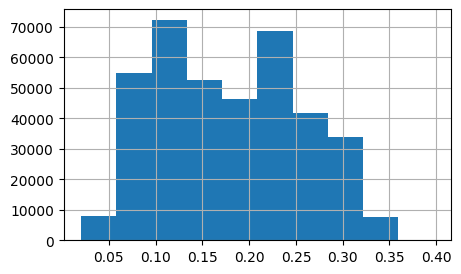

In [33]:
# Продолжим рассматривать не очень понятные признаки типа 'days_since_review'. И следующий признак 'total_number_of_reviews_reviewer_has_given' - количество отзывов,
# которые рецензенты дали в прошлом. И это звучит, как будто это характеристика отеля, которая показывает нам сколько отзывов было дано отелю, и в последующем должно увеличиваться
# от увеличения даты, но характеристика так не ведёт себя. Было предположение, что это характеристика именно оценки, которую рецензент поставил отелю на основе своего опыта.
# Но тоже проанализировав по конкретным оценкам, признак ведёт себя не предсказуемо (т.е. он должен увеличиваться от даты по конкретной оценке - этого не происходит).
# Поэтому предполагаем, что этот признак-счетчик конкретного пользователя/автора отзыва, который зарегистрирован в этой базе данных, и нам просто не предоставлен его ID (чтобы это проверить точно).
# И этот признак показывает количество отзывом, который сделал конкретный автор (с конкретным ID), в связи с этим этот признак переделаем в категориальный номинальный признак с
# 4-мя группами (4 значения: новичок до 100 отзывом (novice), компетентный от 101 до 200 отзывом (competent), опытный от 201 до 300 отзывов(proficient),
# эксперт более 300 отзывов (expert)).
hotels_for_iter3['experience_of_reviewer'] = hotels_for_iter3['total_number_of_reviews_reviewer_has_given'].apply(lambda x: 'novice' if x<=100 \
else('competent' if (x>100) & (x<=200) else('proficient' if (x>200) & (x<=300) else 'expert')))

# Далее переходим к признаку average_score - средний балл отеля, рассчитанный на основе последнего комментария за последний год. Довольно неоднозначный признак, с первого взгляда
# он является довольно опасным с точки зрения утечки данных, т.е. если бы он менялся от отзыва к отзыву по конкретному отелю и сразу пересчитывался, то он бы мог подсказывать модели оценки, которые выставлял
# бы рецензент отелю на основе своего опыта (а если бы этот признак отсутствовал, то модель бы сильно ошибалась). Но этот признак не является переменным 
# (от отзыва к отзыву по определенному отелю), а является постоянным коэффициентом для конкретного отеля скорее всего на конечную дату выгрузки (на 2017-08-03).
# Такими же постоянными признаками являются 'additional_number_of_scoring'- оценка сервиса без отзыва (то есть также некоторые гости, которые просто поставили оценку сервису,
# но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки) и признак 'total_number_of_reviews' - общее количество действительных отзывов об отеле.
# Только не понятно, толи это на дату выгрузки (на 2017-08-03), толи во временной интервал выгрузки (с начальной даты выгрузки данных - 2015-08-04 до конечной даты выгрузки - 2017-08-03).
# В любом случае эти постоянные признаки (как, например, название отеля) для конкретных отелей скорее всего не будут сильно влиять на прогноз модели, но это проверим, когда будем отбирать признаки.
# Можем, также ввести новый признак отношение оценки сервиса без отзыва к общему количеству действительных отзывов. Этот признак будет характеризовать во сколько раз больше отзывов 
# было оставлено, чем проставлено просто оценок.(таким образом мы можем уменьшить кол-во столбцов и уменьшим масштаб признаков, и получим более нормированный признак)
hotels_for_iter3['ratio_additional_number_of_scoring_to_the_total_number_of_reviews'] = hotels_for_iter3['additional_number_of_scoring']/hotels_for_iter3['total_number_of_reviews']
hotels_for_iter3['ratio_additional_number_of_scoring_to_the_total_number_of_reviews'].hist(figsize=(5,3));

In [34]:
# Переходим к самим отзывам, к довольно значимым признакам. Попробуем переработать признаки, характеризующие отзывы, и на основе их разделить отзывы по эмоциональному окрасу.
# Попытаемся разделить отзывы на несколько групп по окрасу отзыва (точно негативный, точно позитивный, скорее негативный, скорее позитивный, скорее нейтральный).
# Проведем это разделение исходя из следующих логических и психологических допущений. А именно, если в признаке 'positive_review' указано 'No Positive', то это точно негативный окрас отзыва,
# если же в признаке 'negative_review' указано 'No Negative', то это точно позитивный окрас отзыва. Дальше допускаем следующее, что если человек чем-то недоволен,
# то в признаке 'negative_review' будет написано больше слов, чем в признаке 'positive_review', т.е. скорее негативный окрас отзыва. И наоборот, кому всё понравилось, будет оставлять отзыв 
# в признаке 'positive_review' из большего количества слов, чем в признаке 'negative_review', т.е. скорее позитивный окрас отзыва, ну а если уж эти признаки равны между собой
# по количеству слов, то это скорее всего нейтральный окрас отзыва. Но также будем проверять на наличие часто встречающихся слов в положительных отзывах и отрицательных отзывах.

# Проверим количество слов в только негативных и только в позитивных отзывах. Должно быть 0 в обоих случаях:
print('Количество слов в только негативных и только в позитивных отзывах составляет: {} слов.' \
.format(hotels_for_iter3[hotels_for_iter3['positive_review']=='No Positive']['review_total_positive_word_counts'].sum() + \
hotels_for_iter3[hotels_for_iter3['negative_review']=='No Negative']['review_total_negative_word_counts'].sum()))

print('Всего точно негативных и точно позитивных отзывов {:.2f}% от всей выборки. Остальные отзывы нужно размечать.' \
.format((hotels_for_iter3[hotels_for_iter3['negative_review']=='No Negative']['negative_review'].count() + \
hotels_for_iter3[hotels_for_iter3['positive_review']=='No Positive']['positive_review'].count())/hotels_for_iter3.shape[0]*100)) 

Количество слов в только негативных и только в позитивных отзывах составляет: 0.0 слов.
Всего точно негативных и точно позитивных отзывов 31.75% от всей выборки. Остальные отзывы нужно размечать.


In [36]:
# Для этого попытаемся создать словари часто встречающихся слов в позитивных и негативных отзывах.
# Список незначимых слов
#list_insignificant_words =['the','but','for','with','from','out','and','did','was','were','are','had','been','have','that','this','there','which',\
#'they','you','our','when','too','also','some','after','about'] # и другие их надо далее распознать\размечать.....
# Создадим список всех слов в признаке 'negative_review'
#list_negative_review_word=[] # пустой список, в котором будет добавляться возможные варианты слов в негативном отзыве из каждой строки
#l_n=[] # этот список вспомогательный, посмотреть какие слова отсеяли по условию длиной меньше 2-х
#for string in hotels_for_iter3['negative_review']: # проходим по всем строкам в признаке 'negative_review'
#       if string not in 'No Negative':
#        string=string.strip().lower()
#        list_string = re.findall(r'\b\w*\snot\s\b\w*|\b\w*\sn t\s\b\w*|\b\w*n t\s\b\w*|no\s\b\w*|very\s\b\w*|\b[^0-9 ]\w*', string)
#        #string=string.strip().lower().split()
#        print(string)
#        print(list_string)
#        print(len(list_string))
#        for elem in list_string:
#            if len(elem)>2 and elem not in list_insignificant_words:
#                list_negative_review_word.append(elem) # собраны все слова представленные в каждой строке
#            if len(elem)<=2:
#                l_n.append(elem)
# Создадим словарь, чтобы посмотреть часто встречаемые слова в негативных отзывах       
#dict_negative_review= {elem:list_negative_review.count(elem) for elem in set(list_negative_review)} # можно создать словарь через использование генератора словаря        
# С большим количеством значений (6706567) словарь очень долго создается (более 111 мин.), поэтому создадим Series
#sr_negative_review_word = pd.Series(data=list_negative_review_word)

#sr_n = pd.Series(data=l_n) # чтобы посмотреть, что отсортировали
#sr_n.value_counts()

#sr_negative_review_word.value_counts()#[:45] #normalize=True
#sr_negative_review_word.value_counts().to_excel('data/sr_n_1-2.xlsx')

In [ ]:
# Попытка создать свой словарь из негативных и позитивных слов с соответствующей числовой оценкой занимает довольно большое количество времени (на разметку значимых слов и назначение соответствующей числовой эмоциональной оценки).
# Поэтому воспользуемся уже готовым инструментом оценки таким как Natural Language Toolkit (библиотека nltk)

import nltk # библиотека работы с языковыми данными
nltk.download('stopwords') # загрузка корпуса стоп-слов
stop_words = nltk.corpus.stopwords.words('english') # список незначимых в эмоциональном смысле слов
nltk.downloader.download('vader_lexicon') # загрузка корпуса словаря
from nltk.sentiment.vader import SentimentIntensityAnalyzer # загрузка из модуля sentiment.vader анализатора чувствительности SentimentIntensityAnalyzer
sent_analyzer = nltk.sentiment.vader.SentimentIntensityAnalyzer()

# Предварительно оговорим шкалу окрасов и соответствующую ей шкалу оценок. Шкалу окрасов мы договорись взять следующую: точно негативный, точно позитивный, скорее негативный,
# скорее позитивный, скорее нейтральный, а это должно соответствовать пяти интервалам в числовой эмоциональной окраске отзывов. Так как в функция polarity_scores выдает
# словарь с нормализованной эмоциональной оценкой 'compound', то её предел являются [-1;1] 0 - это нейтральный окрас. Поэтому получается следующие интервалы: [-1, -0.6) - это точно негативный 
# (definitely negative), [-0.6, -0.2) - скорее негативный (rather negative), [-0.2, 0.2] - скорее нейтральный (rather neutral), (0.2, 0.6] - скорее позитивный (rather positive) и 
# (0.6, 1] - точно позитивный (definitely positive). Исходя из логики должны быть распределены и оценки, которые рецензент проставил отелю на основе своего опыта, на 5 интервалов:
# оценки в наших данных изменяются от 2,5 до 10, а значит оценки [2.5, 4) - должны оценивать точно негативные отзывы, [4, 5.5) -  скорее негативный окрас отзыва,
# [5.5, 7] - скорее нейтральный, (7, 8.5] - скорее позитивный, (8.5, 10] - точно позитивный.
# Но рассматривая отзывы можно заметить некоторые несостыковки, возможные ошибки (выбросы) такие как: рецензент всем доволен, но ставит низкую оценку или нейтральную в признаке 'reviewer_score',
# так же существует и обратное, рецензент недоволен, но ставит высокую оценку. Это хорошо заметно в крайних точках: точно негативный и точно позитивный окрас отзыва.
# Поэтому охарактеризуем итоговую удовлетворенность рецензента в новый признак 'total_emotional_color_of_the_review' сразу по 2-м эмоциональным оценкам признаков 'positive_review'
# и 'negative_review' (т.е. суммарно по двум эмоциональным окрасам в признаках, т.к. имело место и то, что некоторые рецензенты писали в признак негативных отзывов ('negative_review') то,
# что им понравилось, и наоборот то, что не понравилось писали в признак позитивных отзывов ('positive_review')).
print(f'''Можно заметить, что при отзыве - "Никакого позитива (No Positive)", оценки более 7 баллов рецензенты поставили в \
{hotels_for_iter3[hotels_for_iter3['positive_review']=='No Positive']['reviewer_score'].value_counts(normalize=True).sort_index().loc[7.1:].sum()*100:.0f}% \
случаев от общего числа точно таких отзывов (т.е. ничего хорошего, но довольно высокие оценки).''')
print(f'''А также при отзыве - "Никакого негатива (No Negative)", оценки менее 5.5 баллов рецензенты поставили в \
{hotels_for_iter3[hotels_for_iter3['negative_review']=='No Negative']['reviewer_score'].value_counts(normalize=True).sort_index(ascending=False).loc[5.4:].sum()*100:.0f}% \
случаев от общего числа точно таких отзывов (т.е. ничего плохого, но довольно низкие оценки).''')

hotels_for_iter3['total_emotional_color_of_the_review'] = hotels_for_iter3['negative_review'].apply(lambda x:1 if x=='No Negative' else sent_analyzer.polarity_scores(x)['compound']) \
+ hotels_for_iter3['positive_review'].apply(lambda x:-1 if x=='No Positive' else sent_analyzer.polarity_scores(x)['compound'])
display(hotels_for_iter3['total_emotional_color_of_the_review'].describe())

# Шкала окрасов для интервала -2 до 2 признака 'total_emotional_color_of_the_review' итоговой удовлетворенности рецензента (в виде числового выражения):
hotels_for_iter3['cat_total_emotional_color_of_the_review'] = hotels_for_iter3['total_emotional_color_of_the_review'].apply(lambda x: 'definitely negative' if (x>=-2) & (x<-1.2)\
else('rather negative' if (x>=-1.2) & (x<-0.4) else('rather neutral' if (x>=-0.4) & (x<=0.4) else('rather positive' if (x>0.4) & (x<=1.2) else 'definitely positive'))))

#hotels_for_iter3['total_emotional_color_of_the_review'].hist()
#hotels_for_iter3['cat_total_emotional_color_of_the_review'].value_counts()#.hist()

# Можно попробовать нормализовать (шкалировать) полученный новый признак 'total_emotional_color_of_the_review' с помощью методом RobustScaler, т.к.
# ранее уже отмечалась возможность наличия в данных выбросов.
# для нормализации, стандартизации
#from sklearn import preprocessing
# инициализируем нормализатор RobustScaler
#r_scaler = preprocessing.RobustScaler()
# кодируем признак 'total_emotional_color_of_the_review'
#hotels_for_iter3['total_emotional_color_of_the_review']= r_scaler.fit_transform(hotels_for_iter3[['total_emotional_color_of_the_review']]) # нормализация данного признака практически не изменила метрику

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Хозяин\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Хозяин\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Можно заметить, что при отзыве - "Никакого позитива (No Positive)", оценки более 7 баллов рецензенты поставили в 53% случаев от общего числа точно таких отзывов (т.е. ничего хорошего, но довольно высокие оценки).
А также при отзыве - "Никакого негатива (No Negative)", оценки менее 5.5 баллов рецензенты поставили в 1% случаев от общего числа точно таких отзывов (т.е. ничего плохого, но довольно низкие оценки).


count    386496.000000
mean          0.715369
std           0.858183
min          -1.991100
25%           0.169400
50%           0.777800
75%           1.439100
max           1.999300
Name: total_emotional_color_of_the_review, dtype: float64

*После создания и корректировки некоторых признаков произведем третью итерацию обучения на той же модели с наиболее подготовленными данными и посмотрим изменился ли результат метрики MAPE.*

##  Итерация №3

*Проведем обучение нашей модели на откорректированных данных*.

In [38]:
# попробуем обучить модель после корректировок признаков
hotels_iter3 = hotels_for_iter3.copy()
hotels_iter3 = hotels_iter3.drop(['hotel_address', 'tags', 'review_date', 'days_since_review', 'Country', 'reviewer_nationality', 'negative_review', 'positive_review', \
'hotel_name', 'days_since_review_to_the_end_of_the_upload_date','additional_number_of_scoring','total_number_of_reviews','total_number_of_reviews_reviewer_has_given'], axis=1)

# импортируем библиотеку для работы с кодировщиками
import category_encoders as ce
# создаем объект OneHotEncoder
one_hot_encoder = ce.OneHotEncoder(cols=['City', 'types_of_trips', 'number_of_travelers', 'categories_by_size_and_composition', \
'categories_of_comfort', 'time_after_the_review','reviewer_nationality_popular', 'experience_of_reviewer','cat_total_emotional_color_of_the_review'], use_cat_names=True) # указываем признаки для кодирования
# трансформируем наши данные
hotels_iter3_encrypted = one_hot_encoder.fit_transform(hotels_iter3)
# Разделим набор данных на матрицу наблюдений X и вектор правильных ответов y:
X = hotels_iter3_encrypted.drop(['reviewer_score'], axis=1)
y = hotels_iter3_encrypted['reviewer_score']
# Разделяем исходную выборку на тренировочную и тестовую в соотношении 75/25. Задаем параметр random_state = 42.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.25)

In [39]:
# Создаём объект класса случайный лес для регрессии (создаем модель)
regr = RandomForestRegressor(n_estimators=100, random_state=42)  
      
# Обучаем модель на тренировочном наборе данных  
regr.fit(X_train, y_train)

# Делаем предсказание рейтинга отелей для тестовой выборки
y_test_pred = regr.predict(X_test) 

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются
# Рассчитываем значение метрики Mean Absolute Percentage Error (MAPE-cредняя абсолютная процентная ошибка предсказанных значений от фактических) для тестовой выборки: 
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_test_pred))

MAPE: 0.12714232622005875


*Метрика MAPE снова улучшилась. По сравнению со второй итерацией модель ошибается в среднем в 12,71%, а при второй итерации - 13,67% (улучшение на 0,96%).*

*Проведем дальнейшее исследование по улучшению показателя метрики для более лучшего прогноза модели.*

## Продолжение разведывательного анализа

In [ ]:
# Произведем очистку данных от выбросов.
# Посмотрим на коробчатой диаграмме непосредственно распределение оценок в зависимости от шкалы окрасов отзывов.
fig=px.box(data_frame=hotels_for_iter3 , x='reviewer_score', y='cat_total_emotional_color_of_the_review', notched=True, color='cat_total_emotional_color_of_the_review',
           labels={'cat_total_emotional_color_of_the_review':'Эмоциональный окрас отзывова', 'reviewer_score':'Оценка отелю, которую поставил рецензент'})
fig.update_layout(title_text="Распределение оценок, которые рецензент проставил отелю на основе своего опыта, в зависимости от шкалы окрасов отзывов.", title_font_size=18, title_xanchor='center', title_x=0.5)
fig.show()

![SNOWFALL](diagrams/newplot3.png)

*На диаграмме можно увидеть существование потенциальных аномалий/выбросов, которые находятся за пределами усов (1.5 межквартильных размаха), в отзывах с различной эмоциональной окраской (а именно в отзывах со скорее позитивной окраской rather (positive), точно позитивной (definitely positive) и скорее нейтральной (rather neutral))*

*Так же можно отметить, что распределение оценок от эмоционального окраса не распределённо в границах, которых мы предполагали ранее: [2.5, 4) - должны оценивать точно негативные отзывы, [4, 5.5) -  скорее негативный окрас отзыва, [5.5, 7] - скорее нейтральный, (7, 8.5] - скорее позитивный, (8.5, 10] - точно позитивный. Эти границы межквартильных размахов и самих медиан имеют смещение вправо, т.к. и общее распределение оценок отелю 'reviewer_score' и распределение итогового эмоционального окраса в числовом выражении total_emotional_color_of_the_review имеют правостороннюю асимметрию (и в связи с этим также можно отметить нелинейный пропорциональный характер распределений, но порядковая логика в признаке 'cat_total_emotional_color_of_the_review' сохранена(но только с другими границами - смещенными вправо)).*

In [ ]:
# Итак найдем выбросы для всех типов эмоционального окраса с помощью функции, основанной на методе межквартильного размаха (метод Тьки):
def outliers_iqr_mod(data, feature, left=1.5, right=1.5, log_scale=False):
    if log_scale:
        x=np.log(data[feature])
    else:
        x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x >=lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

# Для точно негативных отзывов (definitely negative)
outliers_def_neg, cleaned_def_neg = outliers_iqr_mod(hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']=='definitely negative'], 'reviewer_score')
print(f'Число выбросов по методу Тьюки в точно негативных отзывах: {outliers_def_neg.shape[0]}')
print(f'Результирующее число записей (очищенных от выбросов значений) в точно негативных отзывах: {cleaned_def_neg.shape[0]} \n')
#print('Нижняя граница поиска выбросов по методу Тьюки в точно негативных отзывах составляет: {:.1f}'.format \
#(hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']=='definitely negative']['reviewer_score'].quantile(0.25)\
#- 1.5*(hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']=='definitely negative']['reviewer_score'].quantile(0.75)\
#- hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']=='definitely negative']['reviewer_score'].quantile(0.25))))
#print('Верхняя граница поиска выбросов по методу Тьюки в точно негативных отзывах составляет: {:.1f} \n'.format \
#(hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']=='definitely negative']['reviewer_score'].quantile(0.75)\
#+ 1.5*(hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']=='definitely negative']['reviewer_score'].quantile(0.75) \
#- hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']=='definitely negative']['reviewer_score'].quantile(0.25))))

# Для точно позитивных отзывов (definitely positive)
outliers_def_pos, cleaned_def_pos = outliers_iqr_mod(hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']=='definitely positive'], 'reviewer_score')
print(f'Число выбросов по методу Тьюки в точно позитивных отзывах: {outliers_def_pos.shape[0]}')
print(f'Результирующее число записей (очищенных от выбросов значений) в точно позитивных отзывах: {cleaned_def_pos.shape[0]} \n')
#print('Нижняя граница поиска выбросов по методу Тьюки в точно позитивных отзывах составляет: {:.1f}'.format \
#(hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']=='definitely positive']['reviewer_score'].quantile(0.25)\
#- 1.5*(hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']=='definitely positive']['reviewer_score'].quantile(0.75)\
#- hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']=='definitely positive']['reviewer_score'].quantile(0.25))))
#print('Верхняя граница поиска выбросов по методу Тьюки в точно позитивных отзывах составляет: {:.1f} \n'.format \
#(hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']=='definitely positive']['reviewer_score'].quantile(0.75)\
#+ 1.5*(hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']=='definitely positive']['reviewer_score'].quantile(0.75) \
#- hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']=='definitely positive']['reviewer_score'].quantile(0.25))))

# Для скорее негативных отзывов (rather negative)
outliers_rat_neg, cleaned_rat_neg = outliers_iqr_mod(hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']=='rather negative'], 'reviewer_score')
print(f'Число выбросов по методу Тьюки в скорее негативных отзывах: {outliers_rat_neg.shape[0]}')
print(f'Результирующее число записей (очищенных от выбросов значений) в скорее негативных отзывах: {cleaned_rat_neg.shape[0]} \n')
#print('Нижняя граница поиска выбросов по методу Тьюки в скорее негативных отзывах составляет: {:.1f}'.format \
#(hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']=='rather negative']['reviewer_score'].quantile(0.25)\
#- 1.5*(hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']=='rather negative']['reviewer_score'].quantile(0.75)\
#- hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']=='rather negative']['reviewer_score'].quantile(0.25))))
#print('Верхняя граница поиска выбросов по методу Тьюки в скорее негативных отзывах составляет: {:.1f} \n'.format \
#(hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']=='rather negative']['reviewer_score'].quantile(0.75)\
#+ 1.5*(hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']=='rather negative']['reviewer_score'].quantile(0.75) \
#- hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']=='rather negative']['reviewer_score'].quantile(0.25))))

# Для скорее позитивных отзывов (rather positive)
outliers_rat_pos, cleaned_rat_pos = outliers_iqr_mod(hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']=='rather positive'], 'reviewer_score')
print(f'Число выбросов по методу Тьюки в скорее позитивных отзывах: {outliers_rat_pos.shape[0]}')
print(f'Результирующее число записей (очищенных от выбросов значений) в скорее позитивных отзывах: {cleaned_rat_pos.shape[0]} \n')
#print('Нижняя граница поиска выбросов по методу Тьюки в скорее позитивных отзывах составляет: {:.1f}'.format \
#(hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']=='rather positive']['reviewer_score'].quantile(0.25)\
#- 1.5*(hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']=='rather positive']['reviewer_score'].quantile(0.75)\
#- hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']=='rather positive']['reviewer_score'].quantile(0.25))))
#print('Верхняя граница поиска выбросов по методу Тьюки в скорее позитивных отзывах составляет: {:.1f} \n'.format \
#(hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']=='rather positive']['reviewer_score'].quantile(0.75)\
#+ 1.5*(hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']=='rather positive']['reviewer_score'].quantile(0.75) \
#- hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']=='rather positive']['reviewer_score'].quantile(0.25))))

# Для скорее нейтральных отзывов (rather neutral)
outliers_rat_neu, cleaned_rat_neu = outliers_iqr_mod(hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']=='rather neutral'], 'reviewer_score')
print(f'Число выбросов по методу Тьюки в скорее нейтральных отзывах: {outliers_rat_neu.shape[0]}')
print(f'Результирующее число записей (очищенных от выбросов значений) в скорее нейтральных отзывах: {cleaned_rat_neu.shape[0]} \n')
#print('Нижняя граница поиска выбросов по методу Тьюки в скорее нейтральных отзывах составляет: {:.1f}'.format \
#(hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']=='rather neutral']['reviewer_score'].quantile(0.25)\
#- 1.5*(hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']=='rather neutral']['reviewer_score'].quantile(0.75)\
#- hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']=='rather neutral']['reviewer_score'].quantile(0.25))))
#print('Верхняя граница поиска выбросов по методу Тьюки в скорее нейтральных отзывах составляет: {:.1f} \n'.format \
#(hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']=='rather neutral']['reviewer_score'].quantile(0.75)\
#+ 1.5*(hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']=='rather neutral']['reviewer_score'].quantile(0.75) \
#- hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']=='rather neutral']['reviewer_score'].quantile(0.25))))

# Сведем полученные данные
#hotels_for_iter3_copy=hotels_for_iter3.copy()
outliers_result =  hotels_for_iter3.drop(hotels_for_iter3.index)
hotels_for_iter3_cleaned = hotels_for_iter3.drop(hotels_for_iter3.index)
for elem in hotels_for_iter3['cat_total_emotional_color_of_the_review'].unique():
    outliers, cleaned = outliers_iqr_mod(hotels_for_iter3[hotels_for_iter3['cat_total_emotional_color_of_the_review']==elem], 'reviewer_score')
    outliers_result = pd.concat([outliers_result, outliers])
    hotels_for_iter3_cleaned = pd.concat([hotels_for_iter3_cleaned, cleaned]).sort_index()
    #display(outliers_result)
    #display(hotels_for_iter3_cleaned)

print(f'Итак, общее число выбросов по методу Тьюки в данных получилось: {outliers_result.shape[0]}. И это составляет {(outliers_result.shape[0]/hotels_for_iter3.shape[0]*100):.2f}% от общего количества строк в данных.')
print(f'А результирующее общее число записей (очищенных от выбросов значений) в данных: {hotels_for_iter3_cleaned.shape[0]} \n')

Число выбросов по методу Тьюки в точно негативных отзывах: 0
Результирующее число записей (очищенных от выбросов значений) в точно негативных отзывах: 11550 

Число выбросов по методу Тьюки в точно позитивных отзывах: 3616
Результирующее число записей (очищенных от выбросов значений) в точно позитивных отзывах: 115219 

Число выбросов по методу Тьюки в скорее негативных отзывах: 0
Результирующее число записей (очищенных от выбросов значений) в скорее негативных отзывах: 27597 

Число выбросов по методу Тьюки в скорее позитивных отзывах: 3216
Результирующее число записей (очищенных от выбросов значений) в скорее позитивных отзывах: 140811 

Число выбросов по методу Тьюки в скорее нейтральных отзывах: 762
Результирующее число записей (очищенных от выбросов значений) в скорее нейтральных отзывах: 83725 

Итак, общее число выбросов по методу Тьюки в данных получилось: 7594. И это составляет 1.96% от общего количества строк в данных.
А результирующее общее число записей (очищенных от выброс

In [42]:
# Откорректируем признаки общее количество слов в отрицательном и положительном отзывах ('review_total_negative_word_counts' и 'review_total_positive_word_counts'), 
# т.к. в некоторых отзывах считаются помимо слов ещё и пробелы (в одних 1 пробел в начале в других 2 пробела в начале и в конце отзыва)
#l_string = []
#for string in hotels_for_iter3_cleaned['negative_review']: # проходим по всем строкам в признаке 'negative_review'
#      if string not in 'No Negative':
#        string=string.strip().lower()
#        list_string = re.findall(r'\sn t\s\b\w*|\b\w*n t\s|[^0-9 ]\w*', string)
#        #string=string.strip().lower().split()
#        #print(string)
#        #print(list_string)
#        #print(len(list_string))
#        l_string.append(len(list_string))
        
#       else:
#           list_string = []
#           l_string.append(len(list_string))

#display(l_string)
#hotels_for_iter3_cleaned['corr_review_total_negative_word_counts']=l_string

hotels_for_iter3_cleaned['corr_review_total_negative_word_counts'] = hotels_for_iter3_cleaned['negative_review'].apply(lambda x: 0 if x in 'No Negative'\
else len(re.findall(r'\sn t\s\b\w*|\b\w*n t\s|[^0-9 ]\w*', x.strip().lower()))).astype('float')# решение в одну стороку без цикла, который показан сверху
hotels_for_iter3_cleaned['corr_review_total_positive_word_counts'] = hotels_for_iter3_cleaned['positive_review'].apply(lambda x: 0 if x in 'No Positive'\
else len(re.findall(r'\sn t\s\b\w*|\b\w*n t\s|[^0-9 ]\w*', x.strip().lower()))).astype('float')


*После очистке данных от выбросов произведем следующую четвертую итерацию обучения на той же модели. Посмотрим изменился ли результат метрики MAPE.*

##  Итерация №4

*Проведем обучение нашей модели*.

In [43]:
# попробуем обучить модель после очистки данных от выбросов
hotels_iter4 = hotels_for_iter3_cleaned.copy()
hotels_iter4 = hotels_iter4.drop(['hotel_address', 'tags', 'review_date', 'days_since_review', 'Country', 'reviewer_nationality', 'negative_review', 'positive_review', \
'hotel_name', 'days_since_review_to_the_end_of_the_upload_date','additional_number_of_scoring','total_number_of_reviews','total_number_of_reviews_reviewer_has_given'], axis=1)

# попробуем добавить в наши данные признак 'hotel_name' в закодированном виде. Для категориального номинального признака с большим количеством значений
# воспользуемся двоичным (бинарным) кодированием (Binary Encoding) из библиотеки category_encoders.
# импортируем библиотеку для работы с кодировщиками
import category_encoders as ce
# создаем объект BinaryEncoder
#bin_encoder = ce.BinaryEncoder(cols=['hotel_name']) # указываем столбцы для кодирования признака 'hotel_name'
# трансформируем наши данные
#hotels_iter4_encrypted=bin_encoder.fit_transform(hotels_iter4) # к сожалению кодирование не улучшило метрику, причем этот признак дублируют информацию, которая существует в признаках с координатами
# создаем объект OneHotEncoder
one_hot_encoder = ce.OneHotEncoder(cols=['City', 'types_of_trips', 'number_of_travelers', 'categories_by_size_and_composition', \
'categories_of_comfort', 'time_after_the_review','reviewer_nationality_popular', 'experience_of_reviewer', 'cat_total_emotional_color_of_the_review'], use_cat_names=True) # указываем признаки для кодирования
# трансформируем наши данные
hotels_iter4_encrypted = one_hot_encoder.fit_transform(hotels_iter4)

# Разделим набор данных на матрицу наблюдений X и вектор правильных ответов y:
X = hotels_iter4_encrypted.drop(['reviewer_score'], axis=1)
y = hotels_iter4_encrypted['reviewer_score']
# Разделяем исходную выборку на тренировочную и тестовую в соотношении 75/25. Задаем параметр random_state = 42.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.25)

In [44]:
# Создаём объект класса случайный лес для регрессии (создаем модель)
regr = RandomForestRegressor(n_estimators=100, random_state=42)  
      
# Обучаем модель на тренировочном наборе данных  
regr.fit(X_train, y_train)

# Делаем предсказание рейтинга отелей для тестовой выборки
y_test_pred = regr.predict(X_test) 

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются
# Рассчитываем значение метрики Mean Absolute Percentage Error (MAPE-cредняя абсолютная процентная ошибка предсказанных значений от фактических) для тестовой выборки: 
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_test_pred)) 

MAPE: 0.11603928517401775


*Проведя обучение на более корректных данных метрика MAPE вновь улучшилась. По сравнению с третьей итерацией модель ошибается в среднем в 11,60% случаев, а при третьей итерации - 12,71% (улучшение на 1,11%).*

## Продолжение разведывательного анализа

*В дальнейшем исследование произведем отбор самых важных признаков, оказывающих наибольшее влияние на предсказание модели, разными методами для оптимизации времени обучения.*

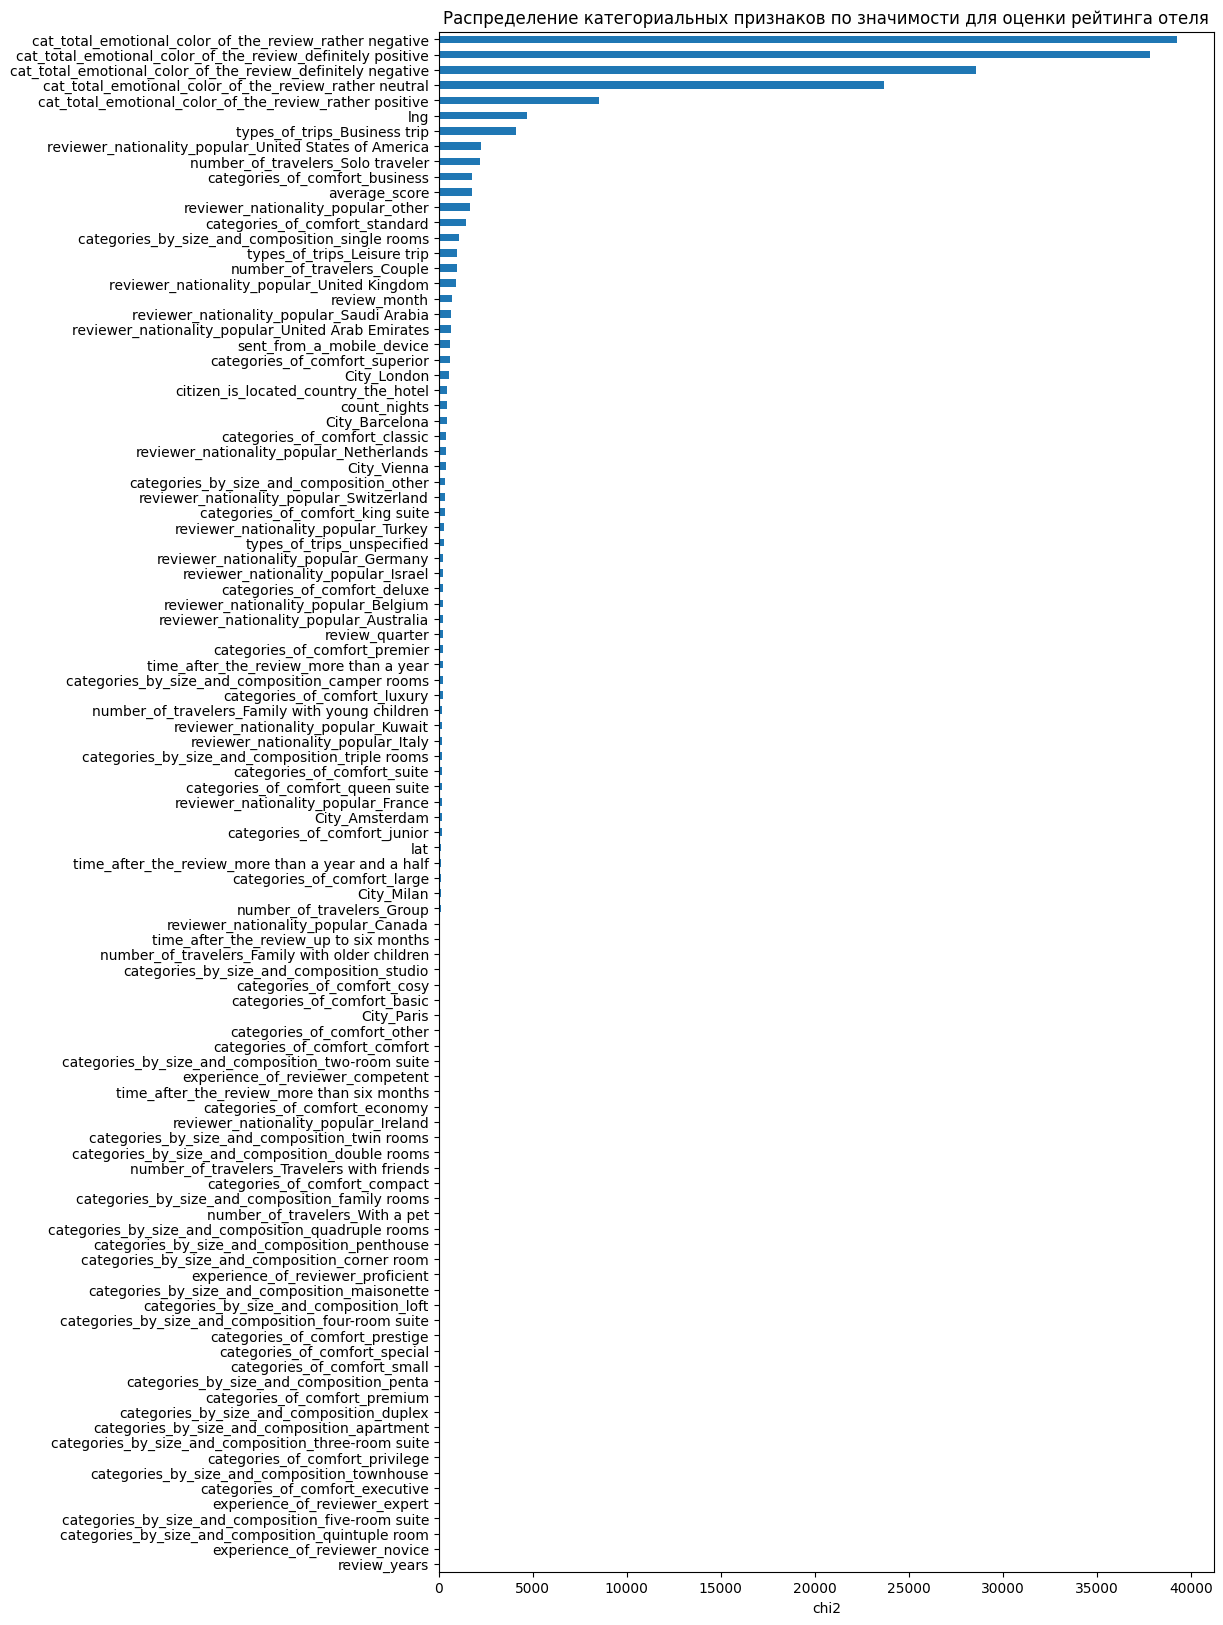

In [45]:
# Проведем оценку значимости каждого признака для целевой переменной — оценка рейтинга отеля. Для этого возьмем последнюю версию выборки для четвертой итерации обучения hotels_iter4_encrypted.
# Первый метод будет основан на статистических тестах и визуализации полученных данных (как связаны разные признаки с целевой переменной).
# Для оценки значимости категориальных признаков будем использовать тест хи-квадрат, для непрерывных признаков — тест ANOVA.

# Для начала разделим признаки по типу
# категориальные признаки (номинальные и порядковые):
cat_cols_list=[list(elem+'_'+hotels_iter4[elem].unique()) for elem in list(hotels_iter4.dtypes[(hotels_iter4.dtypes=='object')].index)] # получается список списков названий (из названия признаков и уникальных элементов в признаке) 
cat_cols=list(hotels_iter4.dtypes[(hotels_iter4.dtypes=='int64')].index)+[elem for item in cat_cols_list for elem in item] \
+ ['average_score','lat','lng'] # порядковые категориальные признаки и бинарные признаки + распокованные все элементы из двумерного в одномерный список
# Можно было взять с закодированных данных hotels_iter4_encrypted:
#cat_cols = list(hotels_iter4_encrypted.dtypes[(hotels_iter4_encrypted.dtypes=='int64')].index)+['average_score','lat','lng']

# непрерывные признаки 
num_cols = [elem for elem in list(hotels_iter4.dtypes[(hotels_iter4.dtypes=='float64')].index) if elem not in ['average_score','lat','lng','reviewer_score']]

from sklearn.feature_selection import chi2 # хи-квадрат
X_for_imp = X.copy()
y_for_imp = y.copy()
y_for_imp=y_for_imp.astype('int')
X_for_imp['lng'] = X_for_imp['lng'].apply(lambda x: abs(x)) # chi2 принимает только положительные величины
imp_cat = pd.Series(chi2(X_for_imp[cat_cols], y_for_imp )[0], index = cat_cols) # рассчитаем chi2 и p-value для каждого признака
imp_cat.sort_values(inplace = True)# сортируем в порядке убывания chi2
imp_cat.plot(kind = 'barh', figsize=(10,20), xlabel='chi2', 
            title='Распределение категориальных признаков по значимости для оценки рейтинга отеля');

Отбираем 5 наиболее значимых признаков в непрерывных признаках. Это признаки: 
total_emotional_color_of_the_review, review_total_negative_word_counts, corr_review_total_negative_word_counts, review_total_positive_word_counts, corr_review_total_positive_word_counts 
Также отбираем и 12 наиболее значимых признаков в категориальных признаках: 
cat_total_emotional_color_of_the_review_rather negative, cat_total_emotional_color_of_the_review_definitely positive, cat_total_emotional_color_of_the_review_definitely negative, cat_total_emotional_color_of_the_review_rather neutral, cat_total_emotional_color_of_the_review_rather positive, lng, types_of_trips_Business trip, reviewer_nationality_popular_United States of America, number_of_travelers_Solo traveler, categories_of_comfort_business, average_score, reviewer_nationality_popular_other


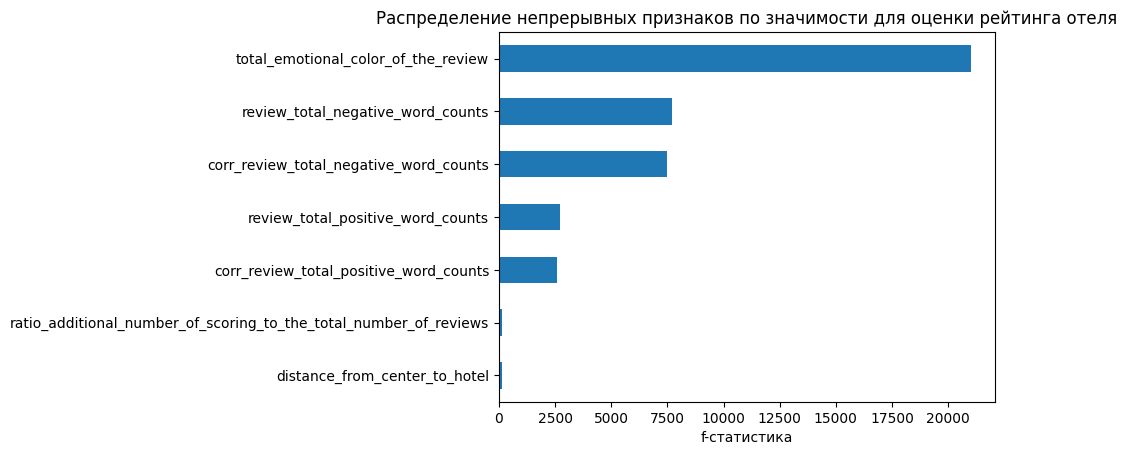

In [46]:
from sklearn.feature_selection import f_classif # anova
imp_num = pd.Series(f_classif(X_for_imp[num_cols], y_for_imp)[0], index = num_cols)# массив f-статистик и p-value для каждого признака
imp_num.sort_values(inplace = True)# сортируем в порядке убывания f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей модели.
imp_num.plot(kind = 'barh', xlabel='f-статистика', 
            title='Распределение непрерывных признаков по значимости для оценки рейтинга отеля');
imp_num.nlargest(5)
print(f'''Отбираем 5 наиболее значимых признаков в непрерывных признаках. Это признаки: \n{", ".join(list(imp_num.nlargest(5).index))} \n\
Также отбираем и 12 наиболее значимых признаков в категориальных признаках: \n{", ".join(list(imp_cat.nlargest(12).index))}''')


*Из графиков видны наиболее связанные с нашим целевым признаком (значимые признаки). Т.е. отбираем 17 признаков, из которых 12 категориальных признаков и 5 непрерывных количественных признаков (следующие признаки: cat_total_emotional_color_of_the_review_rather negative, cat_total_emotional_color_of_the_review_definitely positive, cat_total_emotional_color_of_the_review_definitely negative, cat_total_emotional_color_of_the_review_rather neutral, cat_total_emotional_color_of_the_review_rather positive, lng, types_of_trips_Business trip, reviewer_nationality_popular_United States of America, number_of_travelers_Solo traveler, categories_of_comfort_business, average_score, reviewer_nationality_popular_other, total_emotional_color_of_the_review, review_total_negative_word_counts, corr_review_total_negative_word_counts, review_total_positive_word_counts, corr_review_total_positive_word_counts)*

In [47]:
# Второй способом определения самых важных признаков осуществим с помощью метода выбора признака на основе фильтров (SelectKBest) отберем 17 признаков.
# Отбор реализуем, используя параметры score_func = f_classif для непрерывных количественных признаков и score_func = chi2 для категориальных признаков. 
# В нашей выборке hotels_iter4_encrypted, а соответственно и в X, и y (во всей выборке) все категориальные данные закодированы (переведены в числовые выражения).
# Вызываем метод k лучших переменных и статистические методы дисперсионного анализа ANOVA и хи-квадрата
from sklearn.feature_selection import SelectKBest, f_classif,  chi2
# Производим отбор признаков с помощью метода k лучших переменных (SelectKBest)
selector_num_cols = SelectKBest(score_func=f_classif, k=5).fit(X_for_imp[num_cols], y)
# С помощью метода get_feature_names_out() посмотрим названия признаков, которые отобрал алгоритм SelectKBest
print(selector_num_cols.get_feature_names_out())
# Производим отбор признаков с помощью метода k лучших переменных (SelectKBest)
selector_cat_cols = SelectKBest(score_func=chi2, k=12).fit(X_for_imp[cat_cols], y_for_imp)
# С помощью метода get_feature_names_out() посмотрим названия признаков, которые отобрал алгоритм SelectKBest
print(selector_cat_cols.get_feature_names_out())
# Как можно заметить этим способом были отобраны те же признаки, как и первым способом, т.е. можно сказать это тот же способ только без визуализации.

['review_total_negative_word_counts' 'review_total_positive_word_counts'
 'total_emotional_color_of_the_review'
 'corr_review_total_negative_word_counts'
 'corr_review_total_positive_word_counts']
['types_of_trips_Business trip' 'number_of_travelers_Solo traveler'
 'categories_of_comfort_business' 'reviewer_nationality_popular_other'
 'reviewer_nationality_popular_United States of America'
 'cat_total_emotional_color_of_the_review_rather positive'
 'cat_total_emotional_color_of_the_review_rather negative'
 'cat_total_emotional_color_of_the_review_definitely negative'
 'cat_total_emotional_color_of_the_review_definitely positive'
 'cat_total_emotional_color_of_the_review_rather neutral' 'average_score'
 'lng']


In [48]:
# Третий способ анализа какие наиболее важные признаки в модели случайного леса для регрессии (RandomForestRegressor).
# Так как модель случайного леса для регрессии основана на деревьях решений, у неё также есть атрибут feature_importances_,
# в котором находится коэффициенты важности каждого из признаков.
feature_importances = regr.feature_importances_
# Для наглядности создадим таблицу, а по ней визуализируем как меняются значения коэффициентов важности для признаков в модели случайного леса для регрессии.
data_feature_importances = pd.DataFrame({'Feature':X.columns, 'Coef_importances':feature_importances.round(4)})\
    .sort_values(by='Coef_importances',ascending=False, ignore_index=True)
# Отберем только 17 признаков
display(data_feature_importances.nlargest(17, columns='Coef_importances'))

Feature  Coef_importances
0                 total_emotional_color_of_the_review            0.3652
1              corr_review_total_negative_word_counts            0.0962
2                                       average_score            0.0780
3                   review_total_negative_word_counts            0.0454
4                       distance_from_center_to_hotel            0.0363
5   ratio_additional_number_of_scoring_to_the_tota...            0.0359
6              corr_review_total_positive_word_counts            0.0346
7                                                 lat            0.0332
8                                                 lng            0.0329
9                   review_total_positive_word_counts            0.0313
10                                       review_month            0.0251
11                                       count_nights            0.0185
12                          sent_from_a_mobile_device            0.0068
13                                     review_quarter            0.0065
14                                       review_years            0.0062
15        reviewer_nationality_popular_United Kingdom            0.0056
16                         number_of_travelers_Couple            0.0055

In [ ]:
# Построим столбчатую диаграмму, иллюстрирующую показатели важности для каждого признака.
fig = px.bar(data_frame = data_feature_importances.nlargest(17, columns='Coef_importances'), x='Feature', y='Coef_importances', 
             text='Coef_importances', color='Feature',
             title="Показатели важности для каждого признака.", 
             height =700, width = 1400)
fig.update_layout( uniformtext_minsize=3, uniformtext_mode='show', title_xanchor='center', title_x=0.5) # настраиваем подпись на столбцах диаграммы и заголовок диаграммы
#fig.update_layout( legend=dict( font = dict(size= 12), borderwidth=0.5, orientation= 'h', x= 0.5, y= -0.65,  
#                               xanchor= 'center', yanchor= 'bottom')) # настраиваем легенду
fig.update_traces(showlegend=False)  #Отключаем легенду
#fig.update_yaxes(visible=True, showticklabels=False)
fig.show()

# Наблюдаются некоторые различия в перечне наиболее важных признаков. Посмотрим на результаты метрики MAPE при обучении на различных признаках, полученных разными способами отбора.

![SNOWFALL](diagrams/newplot4.png)

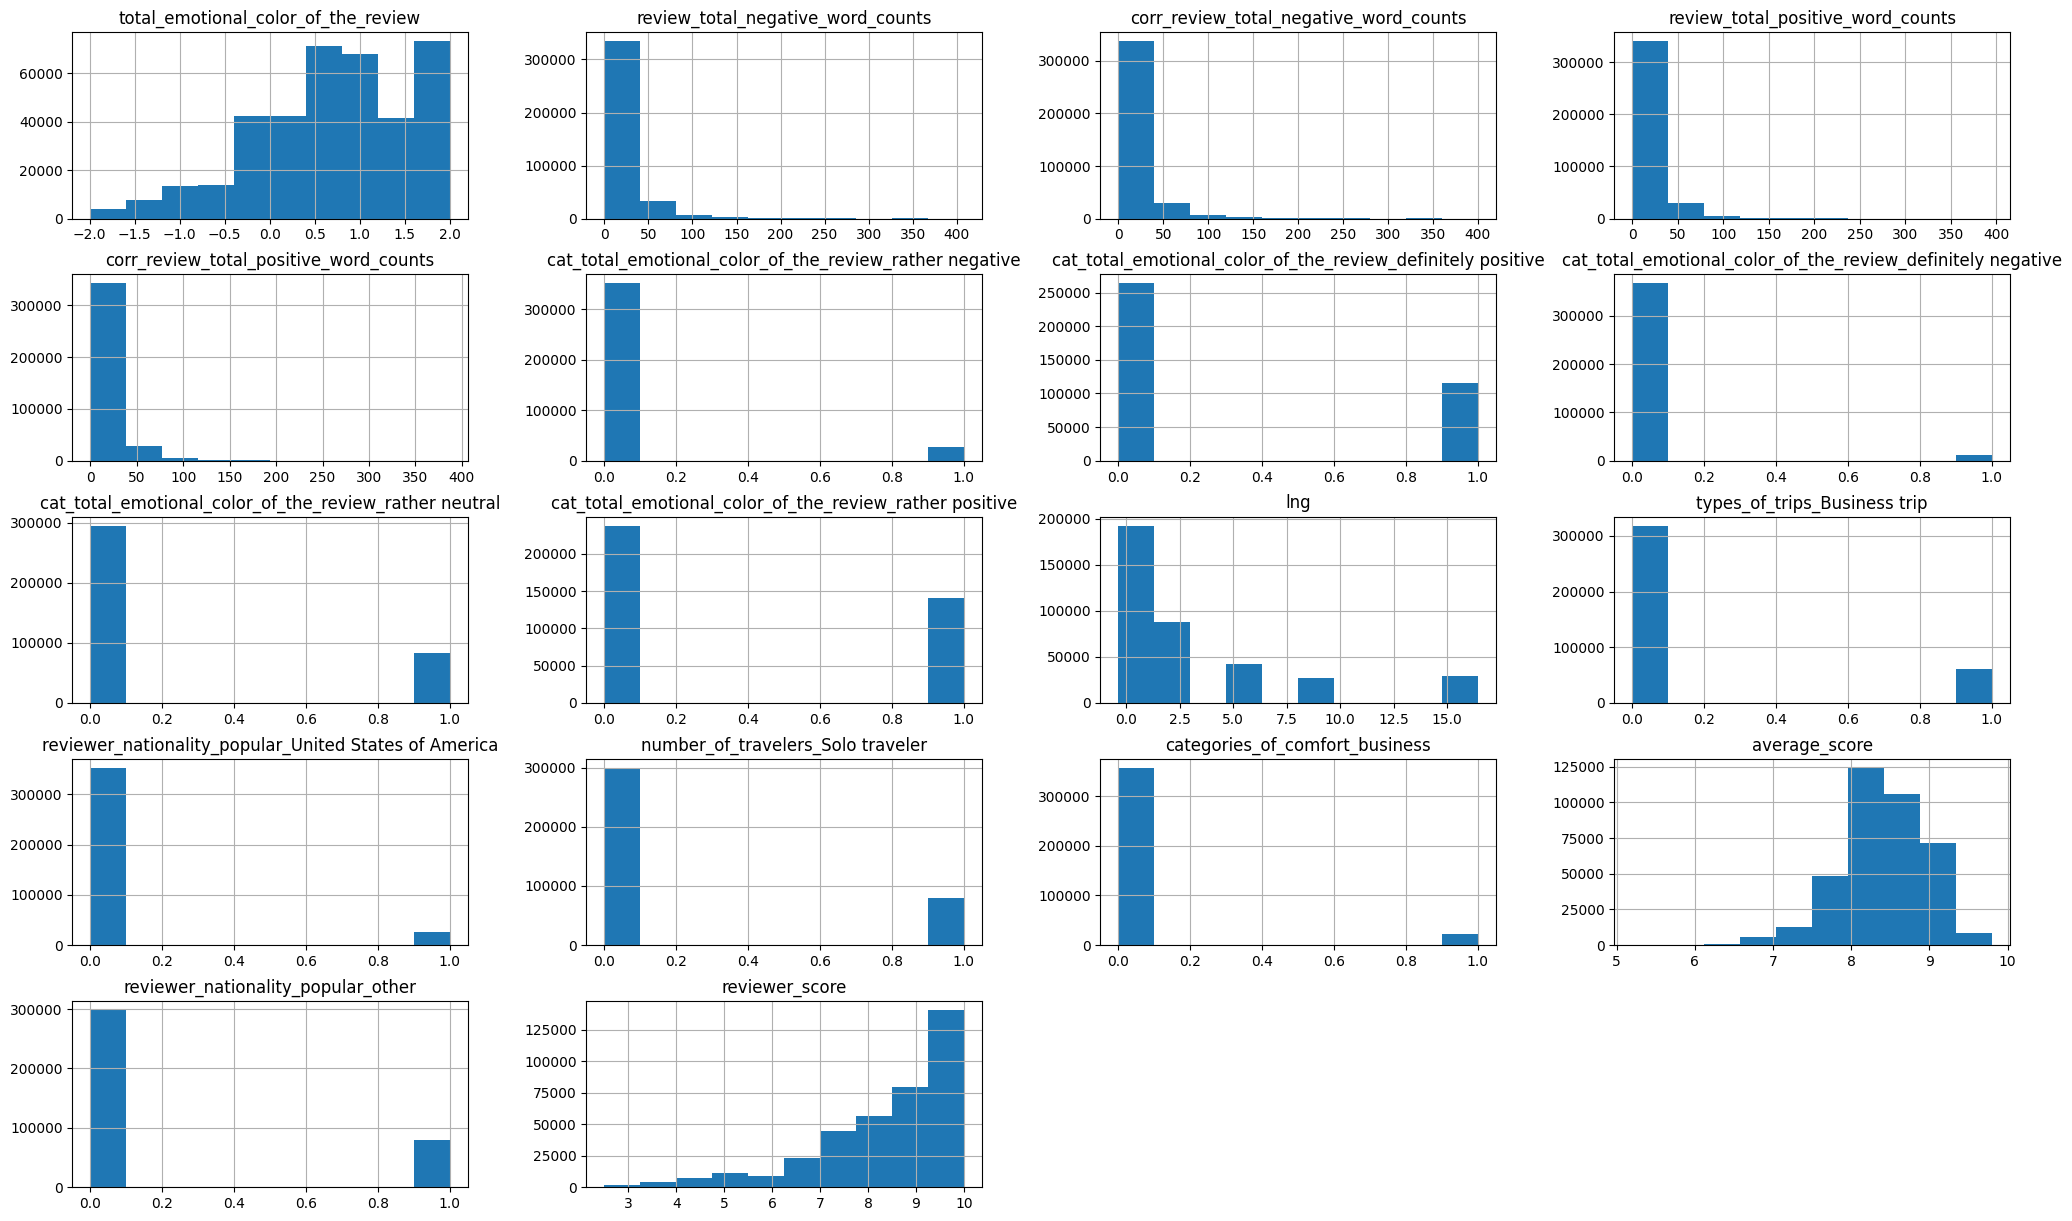

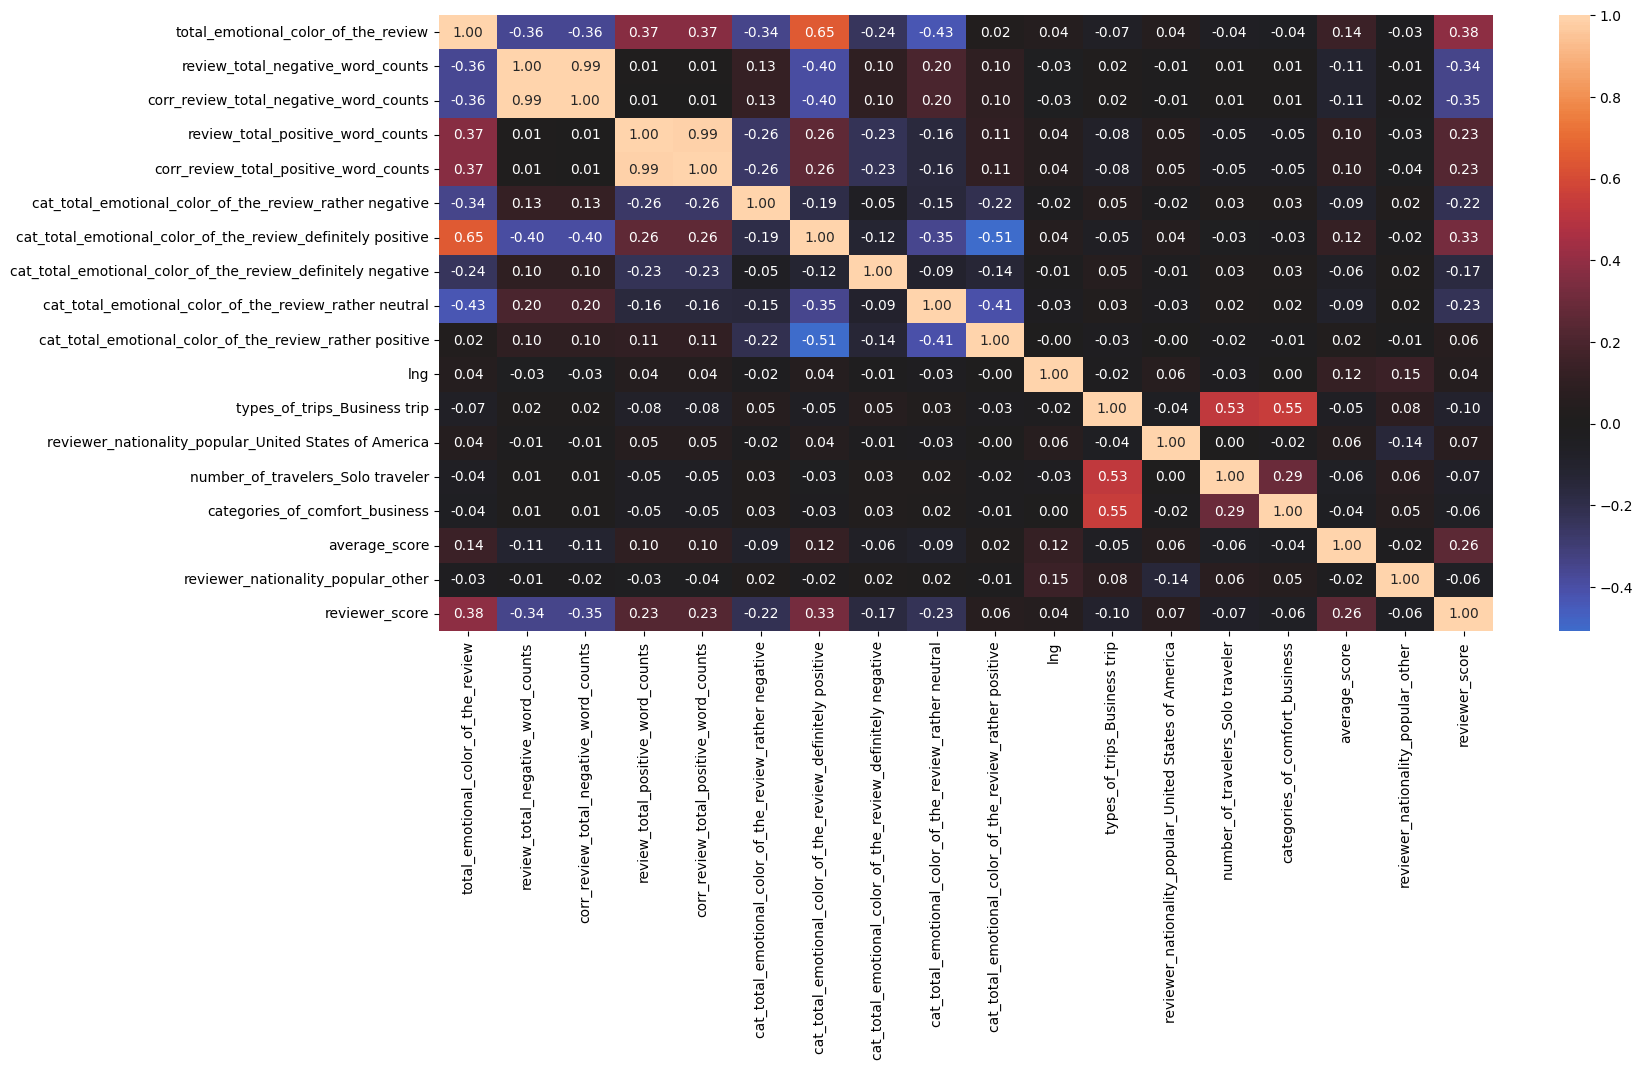

In [51]:
# Посмотрим как распределены наши наиболее важные признаки
hotels_iter4_encrypted_imp1_2 = hotels_iter4_encrypted[list(imp_num.nlargest(5).index) + list(imp_cat.nlargest(12).index) + ['reviewer_score']]
hotels_iter4_encrypted_imp1_2.hist(figsize=(25,15));
#hotels_iter4_encrypted_imp3 = hotels_iter4_encrypted[list(data_feature_importances.nlargest(17, columns='Coef_importances')['Feature'].values) + ['reviewer_score']]
#hotels_iter4_encrypted_imp3.hist(figsize=(25,15));
# Как видно из распределений признаков ни у одиного из признаков не наблюдается нормального распределения в обоих перечнях самых важных признаков.

# Теперь построим график корреляции на тепловой карте на самых важных признаках. И основываясь на этих данных, отметим существует ли и для каких признаков характерна мультиколлинеарность.
# А также посмотрим взаимосвязь(корреляцию) с целевым признаком (с оценкой рейтинга отеля).  Причем для этого более лучше подойдет корреляция Спирмена или Кендалла, т.к.
# у нас в данных у признаков не наблюдается нормального распределения и преобладают в основном категориальные признаки (бинарные признаки и порядковые категориальные).
# А также существует вероятность, что не от всех выбросов и ошибок была проведена очистка, а в связи с этим даже лучше выбрать корреляцию, рассчитанную по Кендаллу.
plt.figure(figsize = (17, 8))
#sns.set(rc = {'figure.figsize':(40, 40)})
sns.heatmap(hotels_iter4_encrypted_imp1_2.corr(method='kendall'), fmt='.2f', annot=True, center=0);
#sns.heatmap(hotels_iter4_encrypted_imp3.corr(method='kendall'), fmt='.2f', annot=True, center=0);

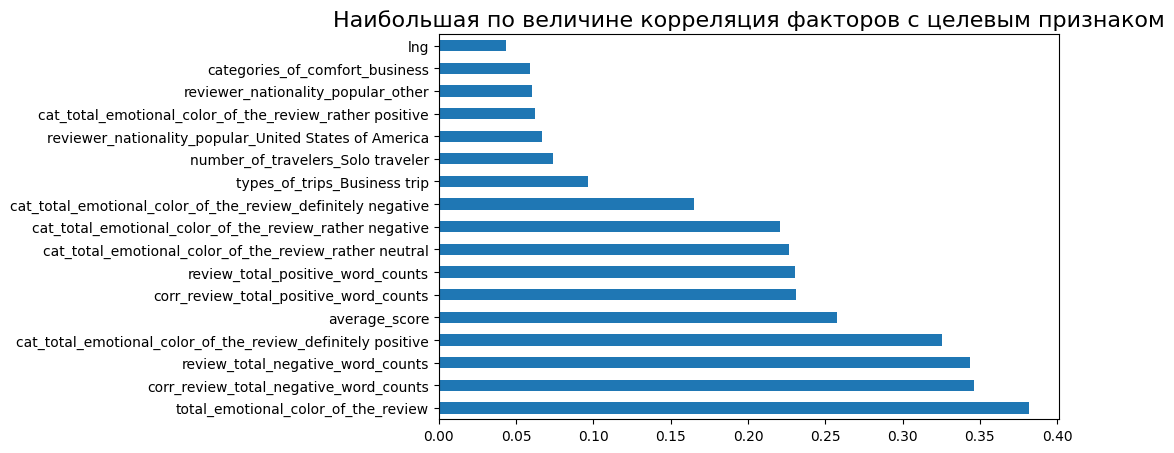

In [52]:
# Наиболее удобно будет посмотреть взаимосвязь признаков к оценки рейтинга отеля в порядоке убывания.
# Находим корреляцию признаков к целевому признаку, сортируем по убыванию величины корреляции
# (без первого, т. к. не забываем, что 1 - это корреляция между одинаковыми признаками)
plt.figure(figsize = (8, 5))
hotels_iter4_encrypted_imp1_2.corr(method='kendall').sort_values(by='reviewer_score', key=lambda x: x.abs(), ascending=False)['reviewer_score'][1:].abs().plot.barh();
#df_encrypted.corr(method='kendall')['reviewer_score'].apply(lambda x: abs(x)).sort_values()[-5:-1]#.plot.barh();
plt.title("Наибольшая по величине корреляция факторов с целевым признаком", fontsize = 16)
plt.show()
#hotels_iter4_encrypted_imp1_2.corr(method='kendall').sort_values(by='reviewer_score', key=lambda x: x.abs(), ascending=False)['reviewer_score'][1:].abs()#.index

*Из диаграмм видно, что между целевым признаком оценки рейтинга отеля и признаками 'total_emotional_color_of_the_review', 'corr_review_total_negative_word_counts', 'review_total_negative_word_counts', 'cat_total_emotional_color_of_the_review_definitely positive' существует слабая связь (взаимосвязь). С остальными признаками целевой признак имеет только очень слабую связь.*

*Мультиколлинеарность (очень сильна связь) в данных существует между признаками 'corr_review_total_negative_word_counts' и 'review_total_negative_word_counts', а также между 'corr_review_total_positive_word_counts' и 'review_total_positive_word_counts', так как значения в этих признаках во многих случаях равны и описывают одно и тоже, т.е. дублируют одну и ту же информацию (и это число слов в позитивных и негативных отзывах, только те признаки, которые были созданы являются более корректными). Поэтому удалим старые признаки 'review_total_negative_word_counts' и 'review_total_positive_word_counts'.*

*После отбора наиболее важных признаков в данных, а также проверки на мультиколлинеарность и взаимосвязь(корреляции) с целевым признаком произведем следующую пятую итерацию обучения на той же модели. Посмотрим изменился ли результат метрики MAPE.*

##  Итерация №5

*Проведем обучение нашей модели*.

In [53]:
# попробуем обучить модель после отбора признаков
hotels_iter5 = hotels_iter4_encrypted.copy()
#hotels_iter5_encrypted = hotels_iter5[list(imp_num.nlargest(5).index) + list(imp_cat.nlargest(12).index) + ['reviewer_score']] # отбор проводился 1 или 2 способом
hotels_iter5_encrypted = hotels_iter5[list(data_feature_importances.nlargest(17, columns='Coef_importances')['Feature'].values) + ['reviewer_score']] # отбор проводился способом через атрибут feature_importances_ в модели случайного леса для регрессии
hotels_iter5_encrypted = hotels_iter5_encrypted.drop(columns=['review_total_negative_word_counts','review_total_positive_word_counts']) # удаляем из-за мультиколлинеарности между признаками
# В выборке для пятой итерации обучения hotels_iter5_encrypted признаки закодированы (переведены в числовые выражения).
# Дальнейшее исследование будем проводить на выборке отбор важных признаков, у которой проводился с помощью коэффициентов важности
# (через атрибут feature_importances_ в модели случайного леса для регрессии), т.к. при обучении с отобранными признаками метрика MAPE (MAPE: 0.1172) показала незначительный, но всё же лучший результат, чем при других способах отбора (MAPE: 0.1183). 

# Разделим набор данных на матрицу наблюдений X и вектор правильных ответов y:
X = hotels_iter5_encrypted.drop(['reviewer_score'], axis=1)
y = hotels_iter5_encrypted['reviewer_score']
# Разделяем исходную выборку на тренировочную и тестовую в соотношении 75/25. Задаем параметр random_state = 42.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.25)

In [54]:
# Создаём объект класса случайный лес для регрессии (создаем модель)
regr = RandomForestRegressor(n_estimators=100, random_state=42)  
      
# Обучаем модель на тренировочном наборе данных  
regr.fit(X_train, y_train)

# Делаем предсказание рейтинга отелей для тестовой выборки
y_test_pred = regr.predict(X_test) 

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются
# Рассчитываем значение метрики Mean Absolute Percentage Error (MAPE-cредняя абсолютная процентная ошибка предсказанных значений от фактических) для тестовой выборки: 
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_test_pred))

MAPE: 0.11718484811060878


*В целом после отбора наиболее важных признаков и удаления мультиколлинеарных признаков метрика MAPE не улучшилась, а немного стала хуже, зато время обучение сократилось. По сравнению с четвертой итерацией модель ошибается в среднем в 11,72% случаев, а при четвертой итерации - 11,60% (незначительное ухудшение на 0,12%).*

## Продолжение разведывательного анализа

*Но и в заключении исследования проведем нормализацию отобранных признаков, оказывающих наибольшее влияние на предсказание модели, и проследим улучшится ли показатели метрики MAPE. Поэтому сразу произведем последнюю шестую итерацию обучения модели.*

##  Итерация №6

*Проведем обучение нашей модели на нормализированных данных*.

In [55]:
# Производим масштабирование данных с помощью нормализации методом RobustScaler, т.к. все-таки существует вероятность, что не от всех выбросов и ошибок была проведена очистка данных.
# для нормализации, стандартизации
from sklearn import preprocessing
# Инициализируем нормализатор  RobustScaler (создаем объект RobustScaler для нормализации)
r_scaler = preprocessing.RobustScaler()
# Вычисляем параметры для нормализации для каждого столбца и производим преобразование всей выборки hotels_iter5_encrypted без целевого признака 'reviewer_score'
hotels_iter5_encrypted_r_scaler = r_scaler.fit_transform(hotels_iter5_encrypted.drop(columns=['reviewer_score']))
# Преобразуем промежуточный датасет в полноценный датафрейм
hotels_iter5_encrypted_r_scaler = pd.DataFrame(hotels_iter5_encrypted_r_scaler, columns=hotels_iter5_encrypted.drop(columns=['reviewer_score']).columns)

# Разделим набор данных на матрицу наблюдений X и вектор правильных ответов y:
X = hotels_iter5_encrypted_r_scaler
y = hotels_iter5_encrypted['reviewer_score']
# Разделяем исходную выборку на тренировочную и тестовую в соотношении 75/25. Задаем параметр random_state = 42.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.25)

In [56]:
# Создаём объект класса случайный лес для регрессии (создаем модель)
regr = RandomForestRegressor(n_estimators=100, random_state=42)  
      
# Обучаем модель на тренировочном наборе данных  
regr.fit(X_train, y_train)

# Делаем предсказание рейтинга отелей для тестовой выборки
y_test_pred = regr.predict(X_test) 

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются
# Рассчитываем значение метрики Mean Absolute Percentage Error (MAPE-cредняя абсолютная процентная ошибка предсказанных значений от фактических) для тестовой выборки: 
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_test_pred))

MAPE: 0.11717888016239104


*В итоге нормализация данных не смогла улучшить метрику MAPE (или скорее совсем незначительно улучшила в десятитысячных процента 11.7185-11.7179=0.0006%), так как алгоритм модели случайного леса не особенно зависит от шкалирования признаков (путем нормализации), т.е. не обязательно приводить все признаки к одному масштабу для обучения модели по этому алгоритму.*

***В результате проведенного исследования самым лучшим показателем метрики MAPE, стало её минимальное значение в четвертой итерации обучения модели и составило 11.60%***